In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
from pathlib import Path
import re

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [32]:
# Load patient summary data
all_patients_df = pd.read_csv("../data/patient_summary.csv")


In [33]:
# Filter for Z01 patients with valid PID and BP data
# Require at least one BP measurement (SBP or DBP)
z01_patients_df = all_patients_df[
    (all_patients_df['primary_icd3'] == 'Z01') & 
    (all_patients_df['pid'].notna()) &
    ((all_patients_df['sbp_latest'].notna()) | (all_patients_df['dbp_latest'].notna()))
].copy()

print(f"Filtered Z01 patients with valid PID and BP data:")
print(f"  Shape: {z01_patients_df.shape}")
print(f"  Total patients: {len(z01_patients_df):,}")
print(f"\nOriginal dataset:")
print(f"  Total patients: {len(all_patients_df):,}")
print(f"  Patients with primary_icd3 == 'Z01': {(all_patients_df['primary_icd3'] == 'Z01').sum():,}")
print(f"  Patients with null pid: {all_patients_df['pid'].isna().sum():,}")
print(f"\nFiltering summary:")
z01_before_bp_filter = all_patients_df[
    (all_patients_df['primary_icd3'] == 'Z01') & 
    (all_patients_df['pid'].notna())
]
patients_dropped = len(z01_before_bp_filter) - len(z01_patients_df)
print(f"  Patients before BP filter: {len(z01_before_bp_filter):,}")
print(f"  Patients dropped (no BP data): {patients_dropped:,}")
print(f"  Patients retained: {len(z01_patients_df):,}")
print(f"\nZ01 patient data quality (after filtering):")
print(f"  Patients with SBP data: {z01_patients_df['sbp_latest'].notna().sum():,} ({z01_patients_df['sbp_latest'].notna().mean()*100:.1f}%)")
print(f"  Patients with DBP data: {z01_patients_df['dbp_latest'].notna().sum():,} ({z01_patients_df['dbp_latest'].notna().mean()*100:.1f}%)")
print(f"  Patients with BMI data: {z01_patients_df['bmi_latest'].notna().sum():,} ({z01_patients_df['bmi_latest'].notna().mean()*100:.1f}%)")


Filtered Z01 patients with valid PID and BP data:
  Shape: (425, 39)
  Total patients: 425

Original dataset:
  Total patients: 6,356
  Patients with primary_icd3 == 'Z01': 427
  Patients with null pid: 0

Filtering summary:
  Patients before BP filter: 427
  Patients dropped (no BP data): 2
  Patients retained: 425

Z01 patient data quality (after filtering):
  Patients with SBP data: 425 (100.0%)
  Patients with DBP data: 424 (99.8%)
  Patients with BMI data: 396 (93.2%)


In [34]:
# Prepare features for Z01 segmentation
print(f"{'='*60}")
print("Preparing features for Z01 segmentation")
print(f"{'='*60}\n")

# Start with a copy
z01_features_df = z01_patients_df.copy()

# Create comorbidity flags from icd3_list
print("Creating comorbidity flags from icd3_list...")
comorbidity_codes = ['I10', 'E11', 'E78']
for code in comorbidity_codes:
    col_name = f'has_{code}'
    # Check if code exists in icd3_list (comma-separated string)
    z01_features_df[col_name] = z01_features_df['icd3_list'].apply(
        lambda x: 1 if pd.notna(x) and code in str(x) else 0
    ).astype(int)
    prevalence = z01_features_df[col_name].mean() * 100
    count = z01_features_df[col_name].sum()
    print(f"  ✓ Created {col_name}: {count:,} patients ({prevalence:.1f}% prevalence)")

# Check prevalence and recommend which flags to keep
print(f"\nComorbidity flag prevalence summary:")
for code in comorbidity_codes:
    col_name = f'has_{code}'
    prevalence = z01_features_df[col_name].mean() * 100
    count = z01_features_df[col_name].sum()
    status = "✓ Keep" if prevalence >= 5.0 else "✗ Skip (low prevalence)"
    print(f"  {col_name}: {count:,} ({prevalence:.1f}%) - {status}")

# Determine which flags to include (prevalence >= 5%)
flags_to_include = []
for code in comorbidity_codes:
    col_name = f'has_{code}'
    if z01_features_df[col_name].mean() * 100 >= 5.0:
        flags_to_include.append(col_name)

print(f"\n✓ Flags to include in feature set: {flags_to_include}")


Preparing features for Z01 segmentation

Creating comorbidity flags from icd3_list...
  ✓ Created has_I10: 84 patients (19.8% prevalence)
  ✓ Created has_E11: 12 patients (2.8% prevalence)
  ✓ Created has_E78: 40 patients (9.4% prevalence)

Comorbidity flag prevalence summary:
  has_I10: 84 (19.8%) - ✓ Keep
  has_E11: 12 (2.8%) - ✗ Skip (low prevalence)
  has_E78: 40 (9.4%) - ✓ Keep

✓ Flags to include in feature set: ['has_I10', 'has_E78']


In [35]:
# Select features for clustering matrix X (~10-12 features)
print(f"{'='*60}")
print("Selecting features for clustering matrix X")
print(f"{'='*60}\n")

# Build feature list (9 features - NO REDUNDANCIES)
# REMOVED: bp_stage (keep sbp_latest only), bmi_latest (keep bmi_class only), sbp_missing (all zeros)
clustering_features = [
    # Reference (keep for tracking, not in X)
    'pid',
    
    # Clinical severity / body comp (2 features - FIXED REDUNDANCY)
    'sbp_latest',    # numeric - BP severity (REMOVED bp_stage redundancy)
    'bmi_class',     # categorical - body composition (REMOVED bmi_latest redundancy)
    
    # Utilization (1 feature)
    'encounter_count_12m',  # primary
    
    # Demographics (2 features)
    'age',           # numeric
    'sex',           # categorical
    
    # Comorbidity (3 features: icd3_count + 2 flags with decent prevalence)
    'icd3_count',    # numeric (preferred over multimorbidity_flag)
]

# Add comorbidity flags with decent prevalence (has_I10, has_E78)
clustering_features.extend(flags_to_include)

# Data quality / missingness (1 feature - REMOVED sbp_missing, all zeros)
clustering_features.extend([
    'bmi_missing',   # binary 0/1
])

# Keep for reporting (not in X, but keep in dataframe)
reporting_features = [
    'bmi_latest',              # for profiling (BMI numeric value)
    'dbp_latest',              # for profiling (diastolic BP)
    'visits_per_year_capped',  # for reporting
    'age_bracket',             # for reporting
    'span_days',               # for profiling
    'mep_region',              # for profiling
]

# Check which columns exist
all_features = clustering_features + reporting_features
missing_cols = [col for col in all_features if col not in z01_features_df.columns]
if missing_cols:
    print(f"  Warning: Missing columns: {missing_cols}")
    # Remove missing columns from lists
    clustering_features = [col for col in clustering_features if col in z01_features_df.columns]
    reporting_features = [col for col in reporting_features if col in z01_features_df.columns]

# Select features (clustering + reporting for reference)
selected_features = clustering_features + reporting_features
z01_features_df = z01_features_df[selected_features].copy()

# Count features for X (excluding pid and reporting features)
features_for_X = [f for f in clustering_features if f != 'pid' and f not in reporting_features]

print(f"✓ Selected {len(features_for_X)} features for clustering matrix X:")
print(f"  Clinical severity/body comp: {len([f for f in features_for_X if f in ['sbp_latest', 'bmi_class']])} features")
print(f"  Utilization: {len([f for f in features_for_X if 'encounter' in f])} features")
print(f"  Demographics: {len([f for f in features_for_X if f in ['age', 'sex']])} features")
print(f"  Comorbidity: {len([f for f in features_for_X if 'icd3' in f or f.startswith('has_')])} features")
print(f"  Data quality: {len([f for f in features_for_X if 'missing' in f])} features")
print(f"\n✓ Kept {len(reporting_features)} reporting features (not in X)")
print(f"\nFinal feature set shape: {z01_features_df.shape}")
print(f"  Features for X: {len(features_for_X)}")
print(f"  Total columns (including pid and reporting): {len(selected_features)}")


Selecting features for clustering matrix X

✓ Selected 9 features for clustering matrix X:
  Clinical severity/body comp: 2 features
  Utilization: 1 features
  Demographics: 2 features
  Comorbidity: 3 features
  Data quality: 1 features

✓ Kept 5 reporting features (not in X)

Final feature set shape: (425, 15)
  Features for X: 9
  Total columns (including pid and reporting): 15


In [36]:
# Feature summary: data types, missing values, and prevalence statistics
print(f"{'='*60}")
print("Feature Summary for Clustering Matrix X")
print(f"{'='*60}\n")

# Features for X (excluding pid and reporting features)
features_for_X = [f for f in z01_features_df.columns if f not in ['pid'] and f not in reporting_features]

print(f"Features for clustering matrix X ({len(features_for_X)} features):\n")
for i, feat in enumerate(features_for_X, 1):
    dtype = z01_features_df[feat].dtype
    missing_count = z01_features_df[feat].isna().sum()
    missing_pct = (missing_count / len(z01_features_df)) * 100
    
    # Additional stats based on feature type
    if feat.startswith('has_'):
        # Binary flag - show prevalence
        prevalence = z01_features_df[feat].mean() * 100
        print(f"  {i:2d}. {feat:20s} | {str(dtype):15s} | Missing: {missing_count:3d} ({missing_pct:5.1f}%) | Prevalence: {prevalence:5.1f}%")
    elif z01_features_df[feat].dtype in ['int64', 'float64']:
        # Numeric - show range
        if missing_count < len(z01_features_df):
            min_val = z01_features_df[feat].min()
            max_val = z01_features_df[feat].max()
            print(f"  {i:2d}. {feat:20s} | {str(dtype):15s} | Missing: {missing_count:3d} ({missing_pct:5.1f}%) | Range: [{min_val:.1f}, {max_val:.1f}]")
        else:
            print(f"  {i:2d}. {feat:20s} | {str(dtype):15s} | Missing: {missing_count:3d} ({missing_pct:5.1f}%) | All missing")
    else:
        # Categorical - show unique values
        unique_count = z01_features_df[feat].nunique()
        print(f"  {i:2d}. {feat:20s} | {str(dtype):15s} | Missing: {missing_count:3d} ({missing_pct:5.1f}%) | Unique values: {unique_count}")

print(f"\n{'='*60}")
print("Comorbidity Flag Prevalence:")
print(f"{'='*60}")
for code in ['I10', 'E11', 'E78']:
    col_name = f'has_{code}'
    if col_name in z01_features_df.columns:
        prevalence = z01_features_df[col_name].mean() * 100
        count = z01_features_df[col_name].sum()
        print(f"  {col_name}: {count:,} patients ({prevalence:.1f}% prevalence)")

print(f"\n{'='*60}")
print("Data Quality Summary:")
print(f"{'='*60}")
print(f"  Total patients: {len(z01_features_df):,}")
# Note: sbp_missing was removed (all zeros after filtering for BP data)
print(f"  Patients with SBP missing: 0 (0.0%) - filtered out in data selection")
print(f"  Patients with BMI missing: {z01_features_df['bmi_missing'].sum():,} ({z01_features_df['bmi_missing'].mean()*100:.1f}%)")

print(f"\n{'='*60}")
print("Feature Matrix X Summary:")
print(f"{'='*60}")
print(f"  Shape: ({len(z01_features_df)}, {len(features_for_X)})")
print(f"  Features: {len(features_for_X)}")
print(f"  Patients: {len(z01_features_df):,}")


Feature Summary for Clustering Matrix X

Features for clustering matrix X (9 features):

   1. sbp_latest           | float64         | Missing:   0 (  0.0%) | Range: [88.0, 191.0]
   2. bmi_class            | object          | Missing:   0 (  0.0%) | Unique values: 5
   3. encounter_count_12m  | int64           | Missing:   0 (  0.0%) | Range: [1.0, 26.0]
   4. age                  | float64         | Missing:   0 (  0.0%) | Range: [4.9, 91.7]
   5. sex                  | object          | Missing:   0 (  0.0%) | Unique values: 2
   6. icd3_count           | int64           | Missing:   0 (  0.0%) | Range: [1.0, 17.0]
   7. has_I10              | int64           | Missing:   0 (  0.0%) | Prevalence:  19.8%
   8. has_E78              | int64           | Missing:   0 (  0.0%) | Prevalence:   9.4%
   9. bmi_missing          | int64           | Missing:   0 (  0.0%) | Range: [0.0, 1.0]

Comorbidity Flag Prevalence:
  has_I10: 84 patients (19.8% prevalence)
  has_E78: 40 patients (9.4% pre

In [37]:
# Feature Encoding and Preparation for Clustering
print(f"{'='*60}")
print("Step 4: Feature Encoding and Preparation for Clustering")
print(f"{'='*60}\n")

# Get features for X (excluding pid and reporting features)
features_for_X = [f for f in z01_features_df.columns if f not in ['pid'] and f not in reporting_features]

# Create clustering dataframe
z01_clustering_data = z01_features_df[features_for_X].copy()
patient_ids = z01_features_df['pid'].copy()

print(f"Clustering data shape: {z01_clustering_data.shape}")
print(f"Features: {list(z01_clustering_data.columns)}\n")

# Check missing values
print("Missing values:")
missing_counts = z01_clustering_data.isnull().sum()
print(missing_counts[missing_counts > 0])
if missing_counts.sum() == 0:
    print("  ✓ No missing values")
print()

# Missing Data Handling Strategy
# Do NOT impute missing BP/BMI values broadly - preserve missing data signal
# Missing vitals can form useful "measurement-needed" segment
print(f"{'='*60}")
print("Missing Data Handling Strategy")
print(f"{'='*60}")
print("✓ Do NOT impute clinical vitals (preserve missingness signal)")
print("✓ Gower distance handles NaN naturally")
print("✓ Missing vitals can form useful 'measurement-needed' segment\n")

# Identify feature types
numeric_features = z01_clustering_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = z01_clustering_data.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Feature types:")
print(f"  Numeric: {len(numeric_features)} features")
print(f"  Categorical: {len(categorical_features)} features")
print()

# Prepare data for Gower distance
clustering_data_clean = z01_clustering_data.copy()

# Ensure binary flags are 0/1 (int64)
binary_flags = [f for f in numeric_features if f.startswith('has_') or 'missing' in f]
for col in binary_flags:
    clustering_data_clean[col] = clustering_data_clean[col].astype(int)
    print(f"✓ Ensured {col} is binary (0/1)")

# Convert categorical features to string for Gower, preserving NaN values
print(f"\nPreparing categorical features for Gower distance:")
for col in categorical_features:
    # Convert to string while preserving NaN (don't convert NaN to "nan" string)
    # Gower library handles NaN naturally, so we preserve actual NaN values
    clustering_data_clean[col] = clustering_data_clean[col].apply(
        lambda x: str(x) if pd.notna(x) else np.nan
    )
    n_missing = clustering_data_clean[col].isnull().sum()
    if n_missing > 0:
        print(f"✓ Converted {col} to string for Gower ({n_missing} NaN preserved)")
    else:
        print(f"✓ Converted {col} to string for Gower")

# Numeric features: keep as-is (no scaling for Gower+PAM)
print(f"\nNumeric features (no scaling needed for Gower+PAM):")
for col in [f for f in numeric_features if f not in binary_flags]:
    n_missing = clustering_data_clean[col].isnull().sum()
    if n_missing > 0:
        print(f"  {col}: {n_missing} missing (preserved for Gower)")
    else:
        print(f"  {col}: complete")

print(f"\n{'='*60}")
print("Final Data Summary for Clustering")
print(f"{'='*60}")
print(f"  Shape: {clustering_data_clean.shape}")
print(f"  Patients: {len(clustering_data_clean):,}")
print(f"  Features: {clustering_data_clean.shape[1]}")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Binary flags: {len(binary_flags)}")
print(f"  Total missing values: {clustering_data_clean.isnull().sum().sum()}")
print(f"\n✓ Data prepared for Gower distance computation")


Step 4: Feature Encoding and Preparation for Clustering

Clustering data shape: (425, 9)
Features: ['sbp_latest', 'bmi_class', 'encounter_count_12m', 'age', 'sex', 'icd3_count', 'has_I10', 'has_E78', 'bmi_missing']

Missing values:
Series([], dtype: int64)
  ✓ No missing values

Missing Data Handling Strategy
✓ Do NOT impute clinical vitals (preserve missingness signal)
✓ Gower distance handles NaN naturally
✓ Missing vitals can form useful 'measurement-needed' segment

Feature types:
  Numeric: 7 features
  Categorical: 2 features

✓ Ensured has_I10 is binary (0/1)
✓ Ensured has_E78 is binary (0/1)
✓ Ensured bmi_missing is binary (0/1)

Preparing categorical features for Gower distance:
✓ Converted bmi_class to string for Gower
✓ Converted sex to string for Gower

Numeric features (no scaling needed for Gower+PAM):
  sbp_latest: complete
  encounter_count_12m: complete
  age: complete
  icd3_count: complete

Final Data Summary for Clustering
  Shape: (425, 9)
  Patients: 425
  Feature

In [38]:
# Import required libraries for clustering
import gower
from sklearn.metrics import silhouette_score, silhouette_samples

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"{'='*60}")
print("Step 5: Clustering Setup")
print(f"{'='*60}\n")
print("✓ Imported gower")
print("✓ Imported sklearn metrics")
print(f"✓ Set random seed: {RANDOM_SEED}")

# Custom K-Medoids implementation (PAM algorithm)
# This is needed because sklearn's KMedoids requires precomputed distance matrices
class KMedoids:
    """
    K-Medoids clustering using PAM algorithm with precomputed distance matrix.
    Compatible with Gower distance matrices.
    """
    def __init__(self, n_clusters=3, metric='precomputed', random_state=None, 
                 init='k-medoids++', max_iter=300):
        self.n_clusters = n_clusters
        self.metric = metric
        self.random_state = random_state
        self.init = init
        self.max_iter = max_iter
        self.medoid_indices_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0
    
    def fit(self, X):
        """Fit K-Medoids to precomputed distance matrix X."""
        n_samples = X.shape[0]
        
        # Initialize medoids
        if self.init == 'k-medoids++':
            # K-medoids++ initialization
            np.random.seed(self.random_state)
            medoid_indices = [np.random.randint(n_samples)]
            
            for _ in range(self.n_clusters - 1):
                distances_to_medoids = X[:, medoid_indices]
                # Use nanmin to handle any remaining NaN values gracefully
                min_distances = np.nanmin(distances_to_medoids, axis=1)
                # Select next medoid with probability proportional to distance^2
                probabilities = min_distances ** 2
                probabilities[medoid_indices] = 0  # Don't select existing medoids
                # Handle NaN in probabilities (replace with 0)
                probabilities = np.nan_to_num(probabilities, nan=0.0)
                # Normalize probabilities
                prob_sum = probabilities.sum()
                if prob_sum > 0:
                    probabilities = probabilities / prob_sum
                else:
                    # Fallback: uniform distribution if all probabilities are 0
                    probabilities = np.ones(n_samples) / n_samples
                    probabilities[medoid_indices] = 0
                    probabilities = probabilities / probabilities.sum()
                next_medoid = np.random.choice(n_samples, p=probabilities)
                medoid_indices.append(next_medoid)
        else:
            # Random initialization
            np.random.seed(self.random_state)
            medoid_indices = np.random.choice(n_samples, size=self.n_clusters, replace=False).tolist()
        
        # PAM algorithm
        for iteration in range(self.max_iter):
            # Assign points to nearest medoid
            distances_to_medoids = X[:, medoid_indices]
            # Use nanargmin to handle any remaining NaN values gracefully
            labels = np.nanargmin(distances_to_medoids, axis=1)
            
            # Update medoids
            new_medoid_indices = medoid_indices.copy()
            changed = False
            
            for cluster_id in range(self.n_clusters):
                cluster_mask = labels == cluster_id
                cluster_indices = np.where(cluster_mask)[0]
                
                if len(cluster_indices) == 0:
                    continue
                
                # Find point in cluster that minimizes total distance to other points in cluster
                cluster_distances = X[np.ix_(cluster_indices, cluster_indices)]
                # Use nansum to handle any remaining NaN values gracefully
                total_distances = np.nansum(cluster_distances, axis=1)
                # Use nanargmin to handle any remaining NaN values gracefully
                best_idx_in_cluster = np.nanargmin(total_distances)
                best_medoid = cluster_indices[best_idx_in_cluster]
                
                if best_medoid != medoid_indices[cluster_id]:
                    new_medoid_indices[cluster_id] = best_medoid
                    changed = True
            
            medoid_indices = new_medoid_indices
            self.n_iter_ = iteration + 1
            
            if not changed:
                break
        
        # Final assignment
        distances_to_medoids = X[:, medoid_indices]
        # Use nanargmin to handle any remaining NaN values gracefully
        labels = np.nanargmin(distances_to_medoids, axis=1)
        
        # Calculate inertia (sum of distances to nearest medoid)
        # Use nan-aware sum to handle any remaining NaN values
        inertia = sum(np.nan_to_num(X[i, medoid_indices[labels[i]]], nan=0.0) for i in range(n_samples))
        
        self.medoid_indices_ = medoid_indices
        self.labels_ = labels
        self.inertia_ = inertia
        
        return self
    
    def fit_predict(self, X):
        """Fit K-Medoids and return cluster labels."""
        self.fit(X)
        return self.labels_

print("✓ Created custom KMedoids class (PAM algorithm)")
print(f"\n{'='*60}")


Step 5: Clustering Setup

✓ Imported gower
✓ Imported sklearn metrics
✓ Set random seed: 42
✓ Created custom KMedoids class (PAM algorithm)



In [39]:
# Compute Gower distance matrix
print(f"{'='*60}")
print("Step 6: Computing Gower Distance Matrix")
print(f"{'='*60}\n")

print(f"Computing Gower distance for {len(clustering_data_clean)} patients...")
print(f"This may take a minute...\n")

# Identify categorical features explicitly for gower
cat_features_list = []
for col in clustering_data_clean.columns:
    if clustering_data_clean[col].dtype.name in ['object', 'category']:
        cat_features_list.append(col)

print(f"Categorical features ({len(cat_features_list)}):")
for col in cat_features_list:
    print(f"  - {col}")

# Create a clean copy for Gower computation
gower_data = clustering_data_clean.copy()

# Ensure categorical features are properly formatted for Gower
# Check for any "nan" strings (from improper conversion) and convert back to NaN
for col in cat_features_list:
    if gower_data[col].dtype.name == 'object':
        # Check if there are any "nan" strings that should be actual NaN
        # (This can happen if data was previously converted incorrectly)
        nan_string_mask = gower_data[col].astype(str).str.lower() == 'nan'
        if nan_string_mask.any():
            gower_data.loc[nan_string_mask, col] = np.nan
            print(f"✓ Fixed {col}: converted {nan_string_mask.sum()} 'nan' strings to NaN")
        # Ensure non-NaN values are strings (they should already be from Cell 6)
        # But verify and convert if needed
        non_nan_mask = gower_data[col].notna()
        if non_nan_mask.any():
            # Check if values are already strings
            sample_val = gower_data.loc[non_nan_mask, col].iloc[0] if non_nan_mask.any() else None
            if sample_val is not None and not isinstance(sample_val, str):
                gower_data.loc[non_nan_mask, col] = gower_data.loc[non_nan_mask, col].astype(str)
                print(f"✓ Ensured {col} values are strings")
    else:
        # Convert to string while preserving NaN
        gower_data[col] = gower_data[col].apply(
            lambda x: str(x) if pd.notna(x) else np.nan
        )
        print(f"✓ Converted {col} to string for Gower (NaN preserved)")

# Diagnostic: Check data before Gower computation
print(f"\nData diagnostic before Gower computation:")
print(f"  Total missing values: {gower_data.isnull().sum().sum()}")
print(f"  Missing by column:")
for col in gower_data.columns:
    n_missing = gower_data[col].isnull().sum()
    if n_missing > 0:
        print(f"    {col}: {n_missing} ({n_missing/len(gower_data)*100:.1f}%)")
# Check for "nan" strings in object columns
for col in gower_data.select_dtypes(include=['object']).columns:
    nan_strings = (gower_data[col].astype(str).str.lower() == 'nan').sum()
    if nan_strings > 0:
        print(f"    ⚠ {col}: {nan_strings} 'nan' strings found (should be NaN)")

print(f"\nComputing Gower distance matrix...")

# Compute Gower distance matrix
try:
    gower_dist_matrix = gower.gower_matrix(gower_data)
    
    print(f"\n✓ Gower distance matrix computed")
    print(f"  Shape: {gower_dist_matrix.shape}")
    print(f"  Data type: {gower_dist_matrix.dtype}")
    
    # Check for NaN values
    nan_count = np.isnan(gower_dist_matrix).sum()
    if nan_count > 0:
        print(f"\n⚠ WARNING: Found {nan_count} NaN values in distance matrix!")
        print(f"  This is {nan_count/(gower_dist_matrix.size)*100:.2f}% of all distances")
        # Diagnose which pairs have NaN distances
        nan_pairs = np.where(np.isnan(gower_dist_matrix))
        unique_rows_with_nan = len(np.unique(nan_pairs[0]))
        unique_cols_with_nan = len(np.unique(nan_pairs[1]))
        print(f"  Rows with NaN: {unique_rows_with_nan} ({unique_rows_with_nan/len(gower_data)*100:.1f}%)")
        print(f"  Cols with NaN: {unique_cols_with_nan} ({unique_cols_with_nan/len(gower_data)*100:.1f}%)")
        # Check if diagonal has NaN (shouldn't, as distance to self should be 0)
        diagonal_nan = np.isnan(np.diag(gower_dist_matrix)).sum()
        if diagonal_nan > 0:
            print(f"  ⚠ WARNING: {diagonal_nan} diagonal elements are NaN (should all be 0)")
    else:
        print(f"  ✓ No NaN values in distance matrix")
    
    # Fix NaN values in distance matrix
    print(f"\n{'─'*60}")
    print("Fixing NaN values in distance matrix...")
    print(f"{'─'*60}")
    
    # 1. Fix diagonal (should always be 0)
    diagonal_nan_before = np.isnan(np.diag(gower_dist_matrix)).sum()
    np.fill_diagonal(gower_dist_matrix, 0.0)
    print(f"✓ Fixed diagonal: set all {len(gower_dist_matrix)} diagonal elements to 0")
    if diagonal_nan_before > 0:
        print(f"  (Fixed {diagonal_nan_before} NaN diagonal values)")
    
    # 2. Fill off-diagonal NaN with median distance
    off_diagonal_mask = ~np.eye(len(gower_dist_matrix), dtype=bool)
    off_diagonal_nan = np.isnan(gower_dist_matrix) & off_diagonal_mask
    off_diagonal_nan_count = off_diagonal_nan.sum()
    
    if off_diagonal_nan_count > 0:
        # Calculate median of non-NaN off-diagonal distances
        off_diagonal_distances = gower_dist_matrix[off_diagonal_mask]
        median_dist = np.nanmedian(off_diagonal_distances)
        gower_dist_matrix[off_diagonal_nan] = median_dist
        print(f"✓ Filled {off_diagonal_nan_count} off-diagonal NaN with median distance: {median_dist:.4f}")
    else:
        print(f"✓ No off-diagonal NaN values to fill")
    
    # 3. Validation checks
    print(f"\nValidation checks:")
    remaining_nan = np.isnan(gower_dist_matrix).sum()
    if remaining_nan == 0:
        print(f"  ✓ No NaN values remaining in distance matrix")
    else:
        print(f"  ⚠ WARNING: {remaining_nan} NaN values still present")
    
    # Check diagonal
    diagonal_check = np.diag(gower_dist_matrix)
    if np.allclose(diagonal_check, 0.0):
        print(f"  ✓ All diagonal elements are 0")
    else:
        non_zero_diag = np.sum(diagonal_check != 0)
        print(f"  ⚠ WARNING: {non_zero_diag} diagonal elements are not 0")
    
    # Check symmetry (Gower distance should be symmetric)
    is_symmetric = np.allclose(gower_dist_matrix, gower_dist_matrix.T)
    if is_symmetric:
        print(f"  ✓ Distance matrix is symmetric")
    else:
        print(f"  ⚠ WARNING: Distance matrix is not symmetric")
        max_asymmetry = np.abs(gower_dist_matrix - gower_dist_matrix.T).max()
        print(f"    Maximum asymmetry: {max_asymmetry:.6f}")
    
    print(f"\nDistance statistics (after NaN fixes):")
    print(f"  Min: {np.nanmin(gower_dist_matrix):.4f}")
    print(f"  Max: {np.nanmax(gower_dist_matrix):.4f}")
    print(f"  Mean: {np.nanmean(gower_dist_matrix):.4f}")
    print(f"  Median: {np.nanmedian(gower_dist_matrix):.4f}")
    print(f"  Std: {np.nanstd(gower_dist_matrix):.4f}")
    
    # Final assertion: ensure no NaN remain
    final_nan_count = np.isnan(gower_dist_matrix).sum()
    if final_nan_count > 0:
        print(f"\n⚠ WARNING: {final_nan_count} NaN values still remain after fixes!")
        print(f"  This may cause issues in clustering. Consider investigating further.")
    else:
        print(f"\n✓ Distance matrix is clean: no NaN values remaining")
    
    # Extract upper triangle (excluding diagonal) for distribution analysis
    upper_triangle_indices = np.triu_indices_from(gower_dist_matrix, k=1)
    upper_triangle_distances = gower_dist_matrix[upper_triangle_indices]
    
    # Remove NaN for percentile calculation
    upper_triangle_distances_clean = upper_triangle_distances[~np.isnan(upper_triangle_distances)]
    
    print(f"\nPairwise distances (upper triangle, n={len(upper_triangle_distances_clean):,}):")
    print(f"  25th percentile: {np.percentile(upper_triangle_distances_clean, 25):.4f}")
    print(f"  50th percentile: {np.percentile(upper_triangle_distances_clean, 50):.4f}")
    print(f"  75th percentile: {np.percentile(upper_triangle_distances_clean, 75):.4f}")
    
except Exception as e:
    print(f"\n❌ ERROR computing Gower distance:")
    print(f"  {str(e)}")
    print(f"\nData info:")
    print(gower_data.info())
    raise

print(f"\n{'='*60}")


Step 6: Computing Gower Distance Matrix

Computing Gower distance for 425 patients...
This may take a minute...

Categorical features (2):
  - bmi_class
  - sex

Data diagnostic before Gower computation:
  Total missing values: 0
  Missing by column:

Computing Gower distance matrix...

✓ Gower distance matrix computed
  Shape: (425, 425)
  Data type: float32
  ✓ No NaN values in distance matrix

────────────────────────────────────────────────────────────
Fixing NaN values in distance matrix...
────────────────────────────────────────────────────────────
✓ Fixed diagonal: set all 425 diagonal elements to 0
✓ No off-diagonal NaN values to fill

Validation checks:
  ✓ No NaN values remaining in distance matrix
  ✓ All diagonal elements are 0
  ✓ Distance matrix is symmetric

Distance statistics (after NaN fixes):
  Min: 0.0000
  Max: 0.8160
  Mean: 0.2861
  Median: 0.2804
  Std: 0.1235

✓ Distance matrix is clean: no NaN values remaining

Pairwise distances (upper triangle, n=90,100):
 

In [40]:
# Run PAM clustering for multiple k values
print(f"{'='*60}")
print("Step 7: PAM (K-Medoids) Clustering")
print(f"{'='*60}\n")

# Define k values to test (OPTIMIZED: reduced from [3,4,5,6,7] for better stability)
k_values = [3, 4, 5]
min_cluster_size = int(0.05 * len(clustering_data_clean))  # 5% threshold

print(f"Testing k values: {k_values}")
print(f"Minimum cluster size (5% threshold): {min_cluster_size} patients")
print(f"Total patients: {len(clustering_data_clean):,}")
print(f"\nSelection criteria:")
print(f"  • Pick smallest k that yields clear, actionable differences")
print(f"  • Keep each cluster ≥ 5% of cohort")
print(f"  • Target silhouette score ≥ 0.15")
print()

# Store results for each k
clustering_results = {}

for k in k_values:
    print(f"\n{'─'*60}")
    print(f"Running PAM clustering with k={k}...")
    print(f"{'─'*60}")
    
    # Fit KMedoids
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=RANDOM_SEED, 
                        init='k-medoids++', max_iter=300)
    
    cluster_labels = kmedoids.fit_predict(gower_dist_matrix)
    
    # Store results
    clustering_results[k] = {
        'model': kmedoids,
        'labels': cluster_labels,
        'medoid_indices': kmedoids.medoid_indices_,
        'inertia': kmedoids.inertia_
    }
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(gower_dist_matrix, cluster_labels, metric='precomputed')
    clustering_results[k]['silhouette'] = silhouette_avg
    
    # Cluster size distribution
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))
    clustering_results[k]['cluster_sizes'] = cluster_sizes
    
    # Check if any cluster is below 5% threshold
    min_size = min(counts)
    min_pct = (min_size / len(clustering_data_clean)) * 100
    meets_size_threshold = min_size >= min_cluster_size
    clustering_results[k]['meets_size_threshold'] = meets_size_threshold
    
    print(f"✓ Clustering complete for k={k}")
    print(f"  Silhouette score: {silhouette_avg:.4f}")
    print(f"  Inertia: {kmedoids.inertia_:.4f}")
    print(f"  Iterations: {kmedoids.n_iter_}")
    print(f"\n  Cluster sizes:")
    for label in sorted(cluster_sizes.keys()):
        size = cluster_sizes[label]
        pct = (size / len(clustering_data_clean)) * 100
        status = "✓" if size >= min_cluster_size else "✗"
        print(f"    {status} Cluster {label}: {size:3d} patients ({pct:5.1f}%)")
    
    if meets_size_threshold:
        print(f"  ✓ All clusters meet 5% threshold")
    else:
        print(f"  ✗ Some clusters below 5% threshold (min: {min_pct:.1f}%)")

print(f"\n{'='*60}")
print("PAM Clustering Summary")
print(f"{'='*60}\n")

print(f"{'k':<5} {'Silhouette':<12} {'Min Size':<10} {'Min %':<10} {'Meets 5%':<10}")
print(f"{'-'*60}")
for k in k_values:
    sil = clustering_results[k]['silhouette']
    sizes = clustering_results[k]['cluster_sizes']
    min_size = min(sizes.values())
    min_pct = (min_size / len(clustering_data_clean)) * 100
    meets = "✓" if clustering_results[k]['meets_size_threshold'] else "✗"
    print(f"{k:<5} {sil:<12.4f} {min_size:<10} {min_pct:<10.1f} {meets:<10}")

print(f"\n{'='*60}")


Step 7: PAM (K-Medoids) Clustering

Testing k values: [3, 4, 5]
Minimum cluster size (5% threshold): 21 patients
Total patients: 425

Selection criteria:
  • Pick smallest k that yields clear, actionable differences
  • Keep each cluster ≥ 5% of cohort
  • Target silhouette score ≥ 0.15


────────────────────────────────────────────────────────────
Running PAM clustering with k=3...
────────────────────────────────────────────────────────────
✓ Clustering complete for k=3
  Silhouette score: 0.1159
  Inertia: 73.2232
  Iterations: 3

  Cluster sizes:
    ✓ Cluster 0:  61 patients ( 14.4%)
    ✓ Cluster 1: 203 patients ( 47.8%)
    ✓ Cluster 2: 161 patients ( 37.9%)
  ✓ All clusters meet 5% threshold

────────────────────────────────────────────────────────────
Running PAM clustering with k=4...
────────────────────────────────────────────────────────────
✓ Clustering complete for k=4
  Silhouette score: 0.2211
  Inertia: 67.6407
  Iterations: 2

  Cluster sizes:
    ✓ Cluster 0:  46 pa

In [41]:
# Create output directory for visualizations
output_dir = Path("outputs/visualizations/z01_clustering")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory: {output_dir}")
print(f"\n{'='*60}")


✓ Output directory: outputs/visualizations/z01_clustering



## Step 8: Silhouette Analysis


In [42]:
# Step 8a: Compute detailed silhouette scores per sample
print(f"{'='*60}")
print("Step 8: Silhouette Analysis")
print(f"{'='*60}\n")

print("Computing silhouette scores for each sample...\n")

for k in k_values:
    labels = clustering_results[k]['labels']
    silhouette_vals = silhouette_samples(gower_dist_matrix, labels, metric='precomputed')
    clustering_results[k]['silhouette_samples'] = silhouette_vals
    
    # Compute per-cluster average silhouettes
    cluster_silhouettes = {}
    for label in np.unique(labels):
        cluster_mask = labels == label
        cluster_silhouettes[label] = silhouette_vals[cluster_mask].mean()
    
    clustering_results[k]['cluster_silhouettes'] = cluster_silhouettes
    
    print(f"k={k}:")
    print(f"  Overall silhouette: {clustering_results[k]['silhouette']:.4f}")
    print(f"  Per-cluster silhouettes:")
    for label in sorted(cluster_silhouettes.keys()):
        print(f"    Cluster {label}: {cluster_silhouettes[label]:.4f}")
    print()

print(f"{'='*60}")


Step 8: Silhouette Analysis

Computing silhouette scores for each sample...

k=3:
  Overall silhouette: 0.1159
  Per-cluster silhouettes:
    Cluster 0: 0.2179
    Cluster 1: 0.0581
    Cluster 2: 0.1503

k=4:
  Overall silhouette: 0.2211
  Per-cluster silhouettes:
    Cluster 0: 0.1343
    Cluster 1: 0.1954
    Cluster 2: 0.1814
    Cluster 3: 0.2603

k=5:
  Overall silhouette: 0.1982
  Per-cluster silhouettes:
    Cluster 0: 0.1447
    Cluster 1: 0.3481
    Cluster 2: 0.2187
    Cluster 3: 0.1906
    Cluster 4: 0.1041



Creating silhouette visualizations...

✓ Saved: outputs/visualizations/z01_clustering/silhouette_analysis.png


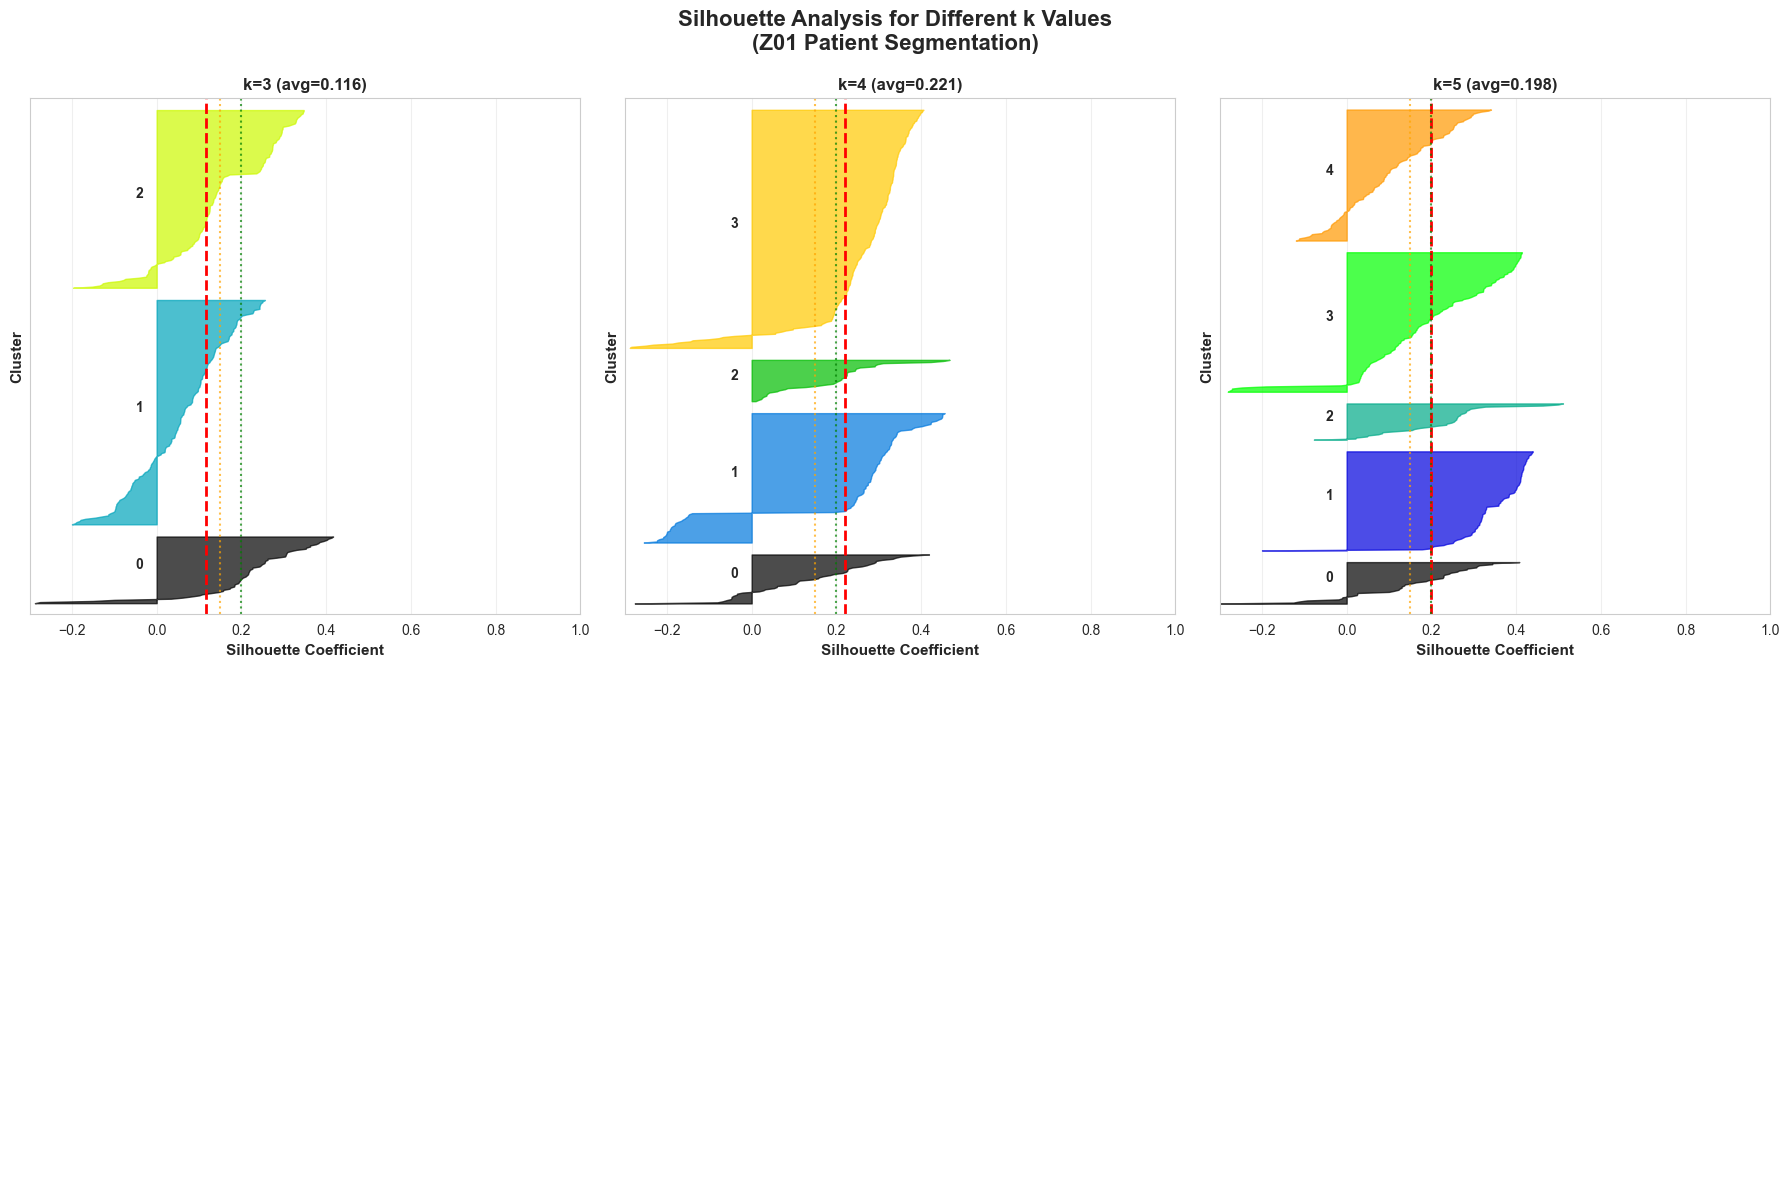

In [43]:
# Step 8b: Create silhouette plots for each k
print("Creating silhouette visualizations...\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    ax = axes[idx]
    labels = clustering_results[k]['labels']
    silhouette_vals = clustering_results[k]['silhouette_samples']
    silhouette_avg = clustering_results[k]['silhouette']
    
    y_lower = 10
    
    for i in range(k):
        # Get silhouette values for cluster i
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=10, fontweight='bold')
        
        y_lower = y_upper + 10  # 10 for the gap between clusters
    
    ax.set_xlabel('Silhouette Coefficient', fontsize=11, fontweight='bold')
    ax.set_ylabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_title(f'k={k} (avg={silhouette_avg:.3f})', fontsize=12, fontweight='bold')
    
    # Add vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2)
    
    # Add reference lines for acceptable thresholds
    ax.axvline(x=0.15, color="orange", linestyle=":", linewidth=1.5, alpha=0.7)
    ax.axvline(x=0.20, color="green", linestyle=":", linewidth=1.5, alpha=0.7)
    
    ax.set_xlim([-0.3, 1])
    ax.set_ylim([0, len(silhouette_vals) + (k + 1) * 10])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis='x')

# Remove unused subplots
for idx in range(len(k_values), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Silhouette Analysis for Different k Values\n(Z01 Patient Segmentation)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

output_path = output_dir / "silhouette_analysis.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")


Creating silhouette comparison plot...

✓ Saved: outputs/visualizations/z01_clustering/silhouette_comparison.png


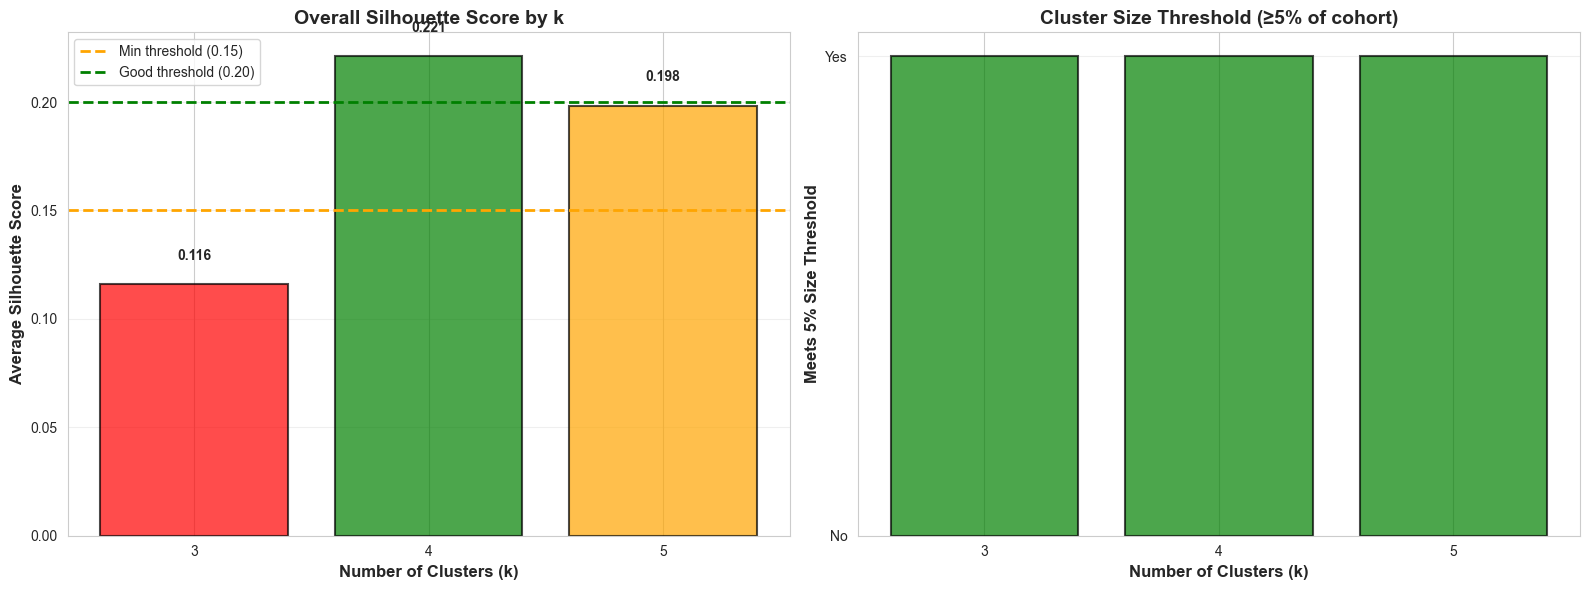


Silhouette Analysis Summary:

k values with silhouette >= 0.15: [4, 5]
k values with silhouette >= 0.20: [4]
k values meeting size threshold: [3, 4, 5]



In [44]:
# Step 8c: Comparison plot of silhouette scores
print("Creating silhouette comparison plot...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall silhouette score by k
silhouette_scores = [clustering_results[k]['silhouette'] for k in k_values]
colors = ['green' if s >= 0.20 else 'orange' if s >= 0.15 else 'red' for s in silhouette_scores]

ax1.bar(k_values, silhouette_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(y=0.15, color='orange', linestyle='--', linewidth=2, label='Min threshold (0.15)')
ax1.axhline(y=0.20, color='green', linestyle='--', linewidth=2, label='Good threshold (0.20)')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_title('Overall Silhouette Score by k', fontsize=14, fontweight='bold')
ax1.set_xticks(k_values)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (k, score) in enumerate(zip(k_values, silhouette_scores)):
    ax1.text(k, score + 0.01, f'{score:.3f}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

# Plot 2: Cluster size meets threshold
threshold_met = [clustering_results[k]['meets_size_threshold'] for k in k_values]
threshold_colors = ['green' if met else 'red' for met in threshold_met]
threshold_values = [1 if met else 0 for met in threshold_met]

ax2.bar(k_values, threshold_values, color=threshold_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Meets 5% Size Threshold', fontsize=12, fontweight='bold')
ax2.set_title('Cluster Size Threshold (≥5% of cohort)', fontsize=14, fontweight='bold')
ax2.set_xticks(k_values)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['No', 'Yes'])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
output_path = output_dir / "silhouette_comparison.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")
print("Silhouette Analysis Summary:")
print(f"{'='*60}\n")

print("k values with silhouette >= 0.15:", [k for k in k_values if clustering_results[k]['silhouette'] >= 0.15])
print("k values with silhouette >= 0.20:", [k for k in k_values if clustering_results[k]['silhouette'] >= 0.20])
print("k values meeting size threshold:", [k for k in k_values if clustering_results[k]['meets_size_threshold']])

print(f"\n{'='*60}")


## Step 9: Stability Analysis (Bootstrap)


In [45]:
# Step 9a: Bootstrap stability analysis
print(f"{'='*60}")
print("Step 9: Stability Analysis (Bootstrap)")
print(f"{'='*60}\n")

# Function to compute Jaccard similarity between two clusterings
def jaccard_similarity(labels1, labels2):
    """
    Compute Jaccard similarity between two clusterings.
    Jaccard = (number of pairs in same cluster in both) / (number of pairs in same cluster in at least one)
    """
    n = len(labels1)
    
    # Create sets of pairs that are in the same cluster
    pairs1 = set()
    pairs2 = set()
    
    for i in range(n):
        for j in range(i+1, n):
            if labels1[i] == labels1[j]:
                pairs1.add((i, j))
            if labels2[i] == labels2[j]:
                pairs2.add((i, j))
    
    # Compute Jaccard similarity
    intersection = len(pairs1 & pairs2)
    union = len(pairs1 | pairs2)
    
    if union == 0:
        return 1.0  # Perfect agreement if no pairs in same cluster
    
    return intersection / union

# Bootstrap parameters
n_bootstrap = 100
bootstrap_fraction = 0.8
n_sample = int(bootstrap_fraction * len(clustering_data_clean))

print(f"Bootstrap parameters:")
print(f"  Iterations: {n_bootstrap}")
print(f"  Sample fraction: {bootstrap_fraction} ({n_sample}/{len(clustering_data_clean)} patients)")
print(f"  Target Jaccard threshold: ≥0.60")
print(f"\nRunning bootstrap stability analysis...")
print(f"This will take several minutes...\n")

# Store stability results
stability_results = {k: [] for k in k_values}

for iteration in range(n_bootstrap):
    if (iteration + 1) % 20 == 0:
        print(f"  Progress: {iteration + 1}/{n_bootstrap} iterations...")
    
    # Create bootstrap sample (80% of patients)
    bootstrap_indices = np.random.choice(len(clustering_data_clean), size=n_sample, replace=False)
    bootstrap_indices = np.sort(bootstrap_indices)
    
    # Extract bootstrap distance matrix
    bootstrap_dist_matrix = gower_dist_matrix[np.ix_(bootstrap_indices, bootstrap_indices)]
    
    # Run clustering for each k on bootstrap sample
    for k in k_values:
        # Get original labels for bootstrap sample
        original_labels = clustering_results[k]['labels'][bootstrap_indices]
        
        # Cluster bootstrap sample
        kmedoids_boot = KMedoids(n_clusters=k, metric='precomputed', 
                                 random_state=RANDOM_SEED + iteration,
                                 init='k-medoids++', max_iter=300)
        bootstrap_labels = kmedoids_boot.fit_predict(bootstrap_dist_matrix)
        
        # Compute Jaccard similarity
        jaccard = jaccard_similarity(original_labels, bootstrap_labels)
        stability_results[k].append(jaccard)

print(f"\n✓ Bootstrap stability analysis complete")
print(f"\n{'='*60}")


Step 9: Stability Analysis (Bootstrap)

Bootstrap parameters:
  Iterations: 100
  Sample fraction: 0.8 (340/425 patients)
  Target Jaccard threshold: ≥0.60

Running bootstrap stability analysis...
This will take several minutes...

  Progress: 20/100 iterations...
  Progress: 40/100 iterations...
  Progress: 60/100 iterations...
  Progress: 80/100 iterations...
  Progress: 100/100 iterations...

✓ Bootstrap stability analysis complete



In [46]:
# Step 9b: Analyze and visualize stability results
print(f"{'='*60}")
print("Stability Analysis Results")
print(f"{'='*60}\n")

# Compute summary statistics
stability_summary = {}
for k in k_values:
    jaccard_scores = stability_results[k]
    stability_summary[k] = {
        'mean': np.mean(jaccard_scores),
        'median': np.median(jaccard_scores),
        'std': np.std(jaccard_scores),
        'min': np.min(jaccard_scores),
        'max': np.max(jaccard_scores),
        'meets_threshold': np.mean(jaccard_scores) >= 0.60
    }
    
    # Store in clustering_results
    clustering_results[k]['stability_jaccard'] = jaccard_scores
    clustering_results[k]['stability_mean'] = stability_summary[k]['mean']
    clustering_results[k]['stability_meets_threshold'] = stability_summary[k]['meets_threshold']

# Print summary table
print(f"{'k':<5} {'Mean Jaccard':<15} {'Median':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Meets ≥0.60':<12}")
print(f"{'-'*80}")
for k in k_values:
    summary = stability_summary[k]
    meets = "✓" if summary['meets_threshold'] else "✗"
    print(f"{k:<5} {summary['mean']:<15.4f} {summary['median']:<10.4f} {summary['std']:<10.4f} "
          f"{summary['min']:<10.4f} {summary['max']:<10.4f} {meets:<12}")

print(f"\n{'='*60}")


Stability Analysis Results

k     Mean Jaccard    Median     Std        Min        Max        Meets ≥0.60 
--------------------------------------------------------------------------------
3     0.3077          0.3070     0.0425     0.2192     0.4485     ✗           
4     0.3615          0.3492     0.0803     0.2317     0.5958     ✗           
5     0.2973          0.2942     0.0569     0.1662     0.4418     ✗           



Creating stability visualizations...

✓ Saved: outputs/visualizations/z01_clustering/stability_analysis.png


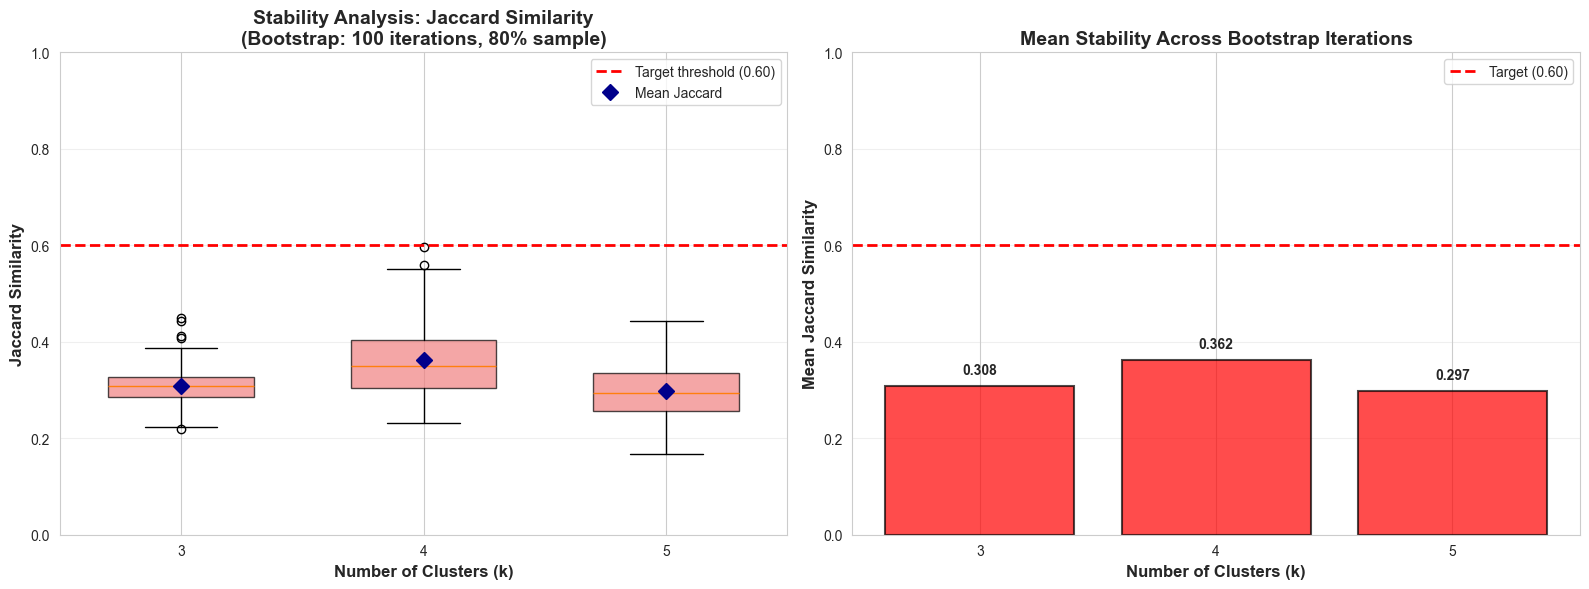


Stability Summary:

k values meeting stability threshold (mean Jaccard ≥ 0.60): []



In [47]:
# Step 9c: Create stability visualizations
print("Creating stability visualizations...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Box plot of Jaccard scores
jaccard_data = [stability_results[k] for k in k_values]
bp = ax1.boxplot(jaccard_data, tick_labels=k_values, patch_artist=True, widths=0.6)

# Color boxes based on mean threshold
for patch, k in zip(bp['boxes'], k_values):
    if stability_summary[k]['meets_threshold']:
        patch.set_facecolor('lightgreen')
    else:
        patch.set_facecolor('lightcoral')
    patch.set_alpha(0.7)

# Add threshold line
ax1.axhline(y=0.60, color='red', linestyle='--', linewidth=2, label='Target threshold (0.60)')

# Add mean points
means = [stability_summary[k]['mean'] for k in k_values]
ax1.plot(range(1, len(k_values) + 1), means, 'D', color='darkblue', 
         markersize=8, label='Mean Jaccard', zorder=3)

ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Jaccard Similarity', fontsize=12, fontweight='bold')
ax1.set_title(f'Stability Analysis: Jaccard Similarity\n(Bootstrap: {n_bootstrap} iterations, 80% sample)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1])

# Plot 2: Mean Jaccard by k
colors_stability = ['green' if stability_summary[k]['meets_threshold'] else 'red' for k in k_values]
ax2.bar(k_values, means, color=colors_stability, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0.60, color='red', linestyle='--', linewidth=2, label='Target (0.60)')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Jaccard Similarity', fontsize=12, fontweight='bold')
ax2.set_title('Mean Stability Across Bootstrap Iterations', fontsize=14, fontweight='bold')
ax2.set_xticks(k_values)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 1])

# Add value labels
for k, mean_val in zip(k_values, means):
    ax2.text(k, mean_val + 0.02, f'{mean_val:.3f}', ha='center', va='bottom',
             fontsize=10, fontweight='bold')

plt.tight_layout()
output_path = output_dir / "stability_analysis.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")
print("Stability Summary:")
print(f"{'='*60}\n")
print("k values meeting stability threshold (mean Jaccard ≥ 0.60):", 
      [k for k in k_values if stability_summary[k]['meets_threshold']])
print(f"\n{'='*60}")


## Step 10: Clinical Validation


In [48]:
# Step 10a: Compute clinical profiles for each k
print(f"{'='*60}")
print("Step 10: Clinical Validation")
print(f"{'='*60}\n")

# Clinical features to profile 
# IMPORTANT: Merge back with original features for comprehensive profiling
# even though some features weren't used in clustering (like dbp_latest)
print("Merging cluster labels with full feature set for profiling...")
print(f"Note: Clustering used {len(features_for_X)} optimized features, profiling shows all metrics\n")

# Create a profiling dataframe by merging z01_features_df with patient_ids
# Match on PID values since indices were reset
profiling_base = z01_features_df[z01_features_df['pid'].isin(patient_ids.values)].copy()
profiling_base = profiling_base.reset_index(drop=True)
profiling_base['array_index'] = range(len(profiling_base))  # Track position

# Define desired clinical features (check availability in full feature set)
desired_clinical = ['sbp_latest', 'dbp_latest', 'bmi_latest', 'age', 'encounter_count_12m', 'icd3_count']
clinical_features = [f for f in desired_clinical if f in profiling_base.columns]

# Comorbidity features - use flags that were included in clustering
desired_comorbidity = ['has_I10', 'has_E78']
# Also check for other common ones for completeness
additional_comorbidity = ['has_E11', 'has_K76', 'has_I70']
comorbidity_features = [f for f in desired_comorbidity + additional_comorbidity if f in profiling_base.columns]

print(f"Available clinical features for profiling: {clinical_features}")
print(f"Available comorbidity features: {comorbidity_features}")
print(f"  (Clustering used: {', '.join(flags_to_include) if 'flags_to_include' in locals() else 'I10, E78'})")
print(f"Cohort: {len(profiling_base)} patients\n")

# Merge cluster labels with original data for profiling
clinical_profiles = {}

for k in k_values:
    print(f"\n{'─'*60}")
    print(f"Clinical Profiles for k={k}")
    print(f"{'─'*60}\n")
    
    labels = clustering_results[k]['labels']
    
    # Create dataframe with labels and ALL features (not just clustering features)
    profile_df = profiling_base.copy()
    profile_df['cluster'] = labels
    
    # Compute summary statistics per cluster
    cluster_profiles = []
    
    for cluster_id in range(k):
        cluster_data = profile_df[profile_df['cluster'] == cluster_id]
        n_patients = len(cluster_data)
        
        profile = {
            'cluster': cluster_id,
            'n_patients': n_patients,
            'pct_patients': (n_patients / len(profile_df)) * 100
        }
        
        # Clinical metrics (median for continuous)
        for feat in clinical_features:
            if feat in cluster_data.columns:
                profile[f'{feat}_median'] = cluster_data[feat].median()
                profile[f'{feat}_mean'] = cluster_data[feat].mean()
                profile[f'{feat}_std'] = cluster_data[feat].std()
        
        # Comorbidity prevalence (percentage)
        for feat in comorbidity_features:
            if feat in cluster_data.columns:
                profile[f'{feat}_pct'] = (cluster_data[feat].sum() / n_patients) * 100
        
        cluster_profiles.append(profile)
    
    # Convert to DataFrame
    profiles_df = pd.DataFrame(cluster_profiles)
    clinical_profiles[k] = profiles_df
    
    # Store in clustering_results
    clustering_results[k]['clinical_profiles'] = profiles_df
    
    # Display key metrics
    has_dbp = 'dbp_latest_median' in profiles_df.columns
    has_bmi = 'bmi_latest_median' in profiles_df.columns
    
    print(f"{'Cluster':<10} {'N':<8} {'%':<8} {'SBP':<10}", end="")
    if has_dbp:
        print(f" {'DBP':<10}", end="")
    if has_bmi:
        print(f" {'BMI':<10}", end="")
    print(f" {'Encounters':<12}")
    print(f"{'-'*70}")
    
    for _, row in profiles_df.iterrows():
        line = f"{int(row['cluster']):<10} {int(row['n_patients']):<8} {row['pct_patients']:<8.1f} "
        line += f"{row['sbp_latest_median']:<10.1f} "
        if has_dbp:
            line += f"{row['dbp_latest_median']:<10.1f} "
        if has_bmi:
            line += f"{row['bmi_latest_median']:<10.1f} "
        line += f"{row['encounter_count_12m_median']:<12.1f}"
        print(line)
    
    # Check SBP differences (clinical meaningfulness)
    sbp_medians = profiles_df['sbp_latest_median'].values
    max_sbp_diff = sbp_medians.max() - sbp_medians.min()
    sbp_range = f"{sbp_medians.min():.1f} - {sbp_medians.max():.1f}"
    
    print(f"\nSBP range across clusters: {sbp_range} mmHg")
    print(f"Max SBP difference: {max_sbp_diff:.1f} mmHg", end="")
    if max_sbp_diff >= 10:
        print(" ✓ (≥10 mmHg)")
        clustering_results[k]['sbp_clinically_distinct'] = True
    else:
        print(" ✗ (<10 mmHg)")
        clustering_results[k]['sbp_clinically_distinct'] = False

print(f"\n{'='*60}")


Step 10: Clinical Validation

Merging cluster labels with full feature set for profiling...
Note: Clustering used 9 optimized features, profiling shows all metrics

Available clinical features for profiling: ['sbp_latest', 'dbp_latest', 'bmi_latest', 'age', 'encounter_count_12m', 'icd3_count']
Available comorbidity features: ['has_I10', 'has_E78']
  (Clustering used: has_I10, has_E78)
Cohort: 425 patients


────────────────────────────────────────────────────────────
Clinical Profiles for k=3
────────────────────────────────────────────────────────────

Cluster    N        %        SBP        DBP        BMI        Encounters  
----------------------------------------------------------------------
0          61       14.4     146.0      89.0       31.5       6.0         
1          203      47.8     128.0      84.0       23.8       2.0         
2          161      37.9     127.0      83.0       28.6       4.0         

SBP range across clusters: 127.0 - 146.0 mmHg
Max SBP difference: 19

Creating clinical validation boxplots...

✓ Saved: outputs/visualizations/z01_clustering/clinical_boxplots_k3.png


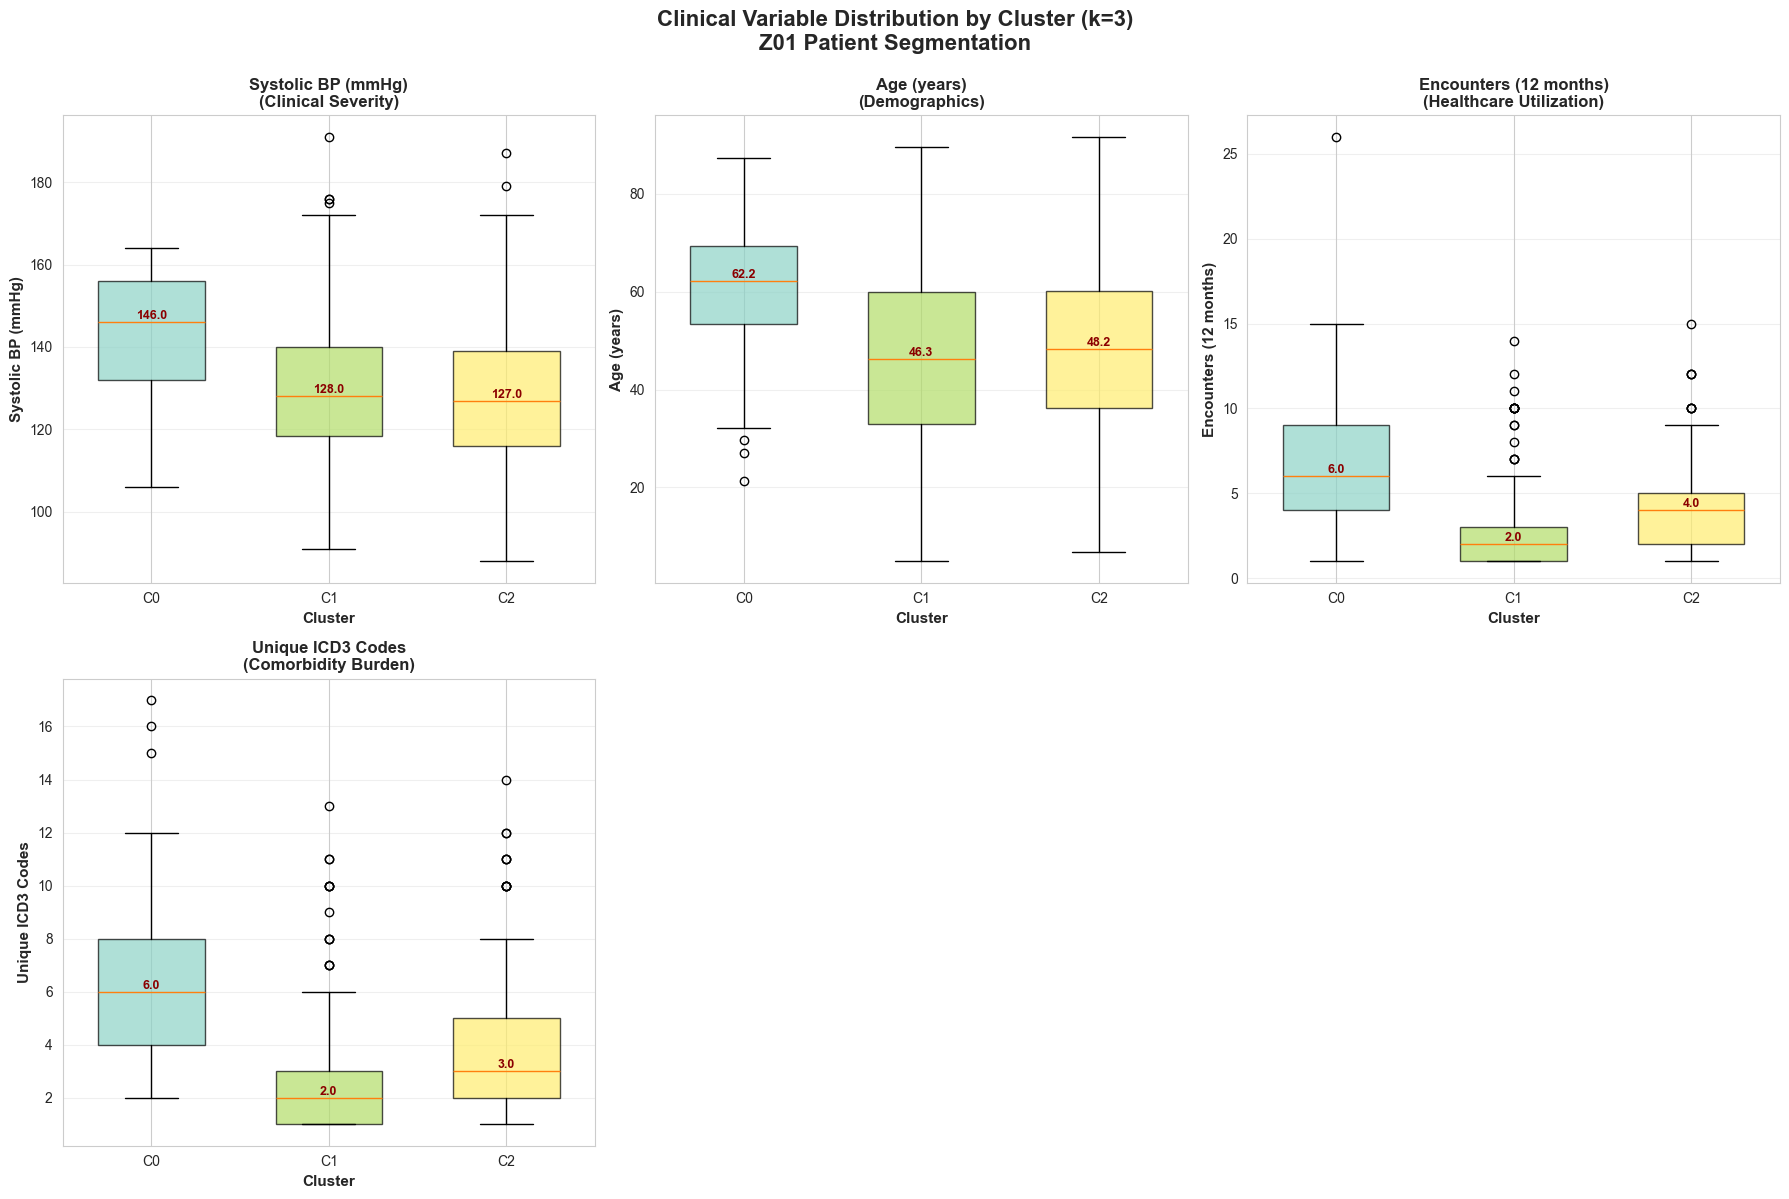

✓ Saved: outputs/visualizations/z01_clustering/clinical_boxplots_k4.png


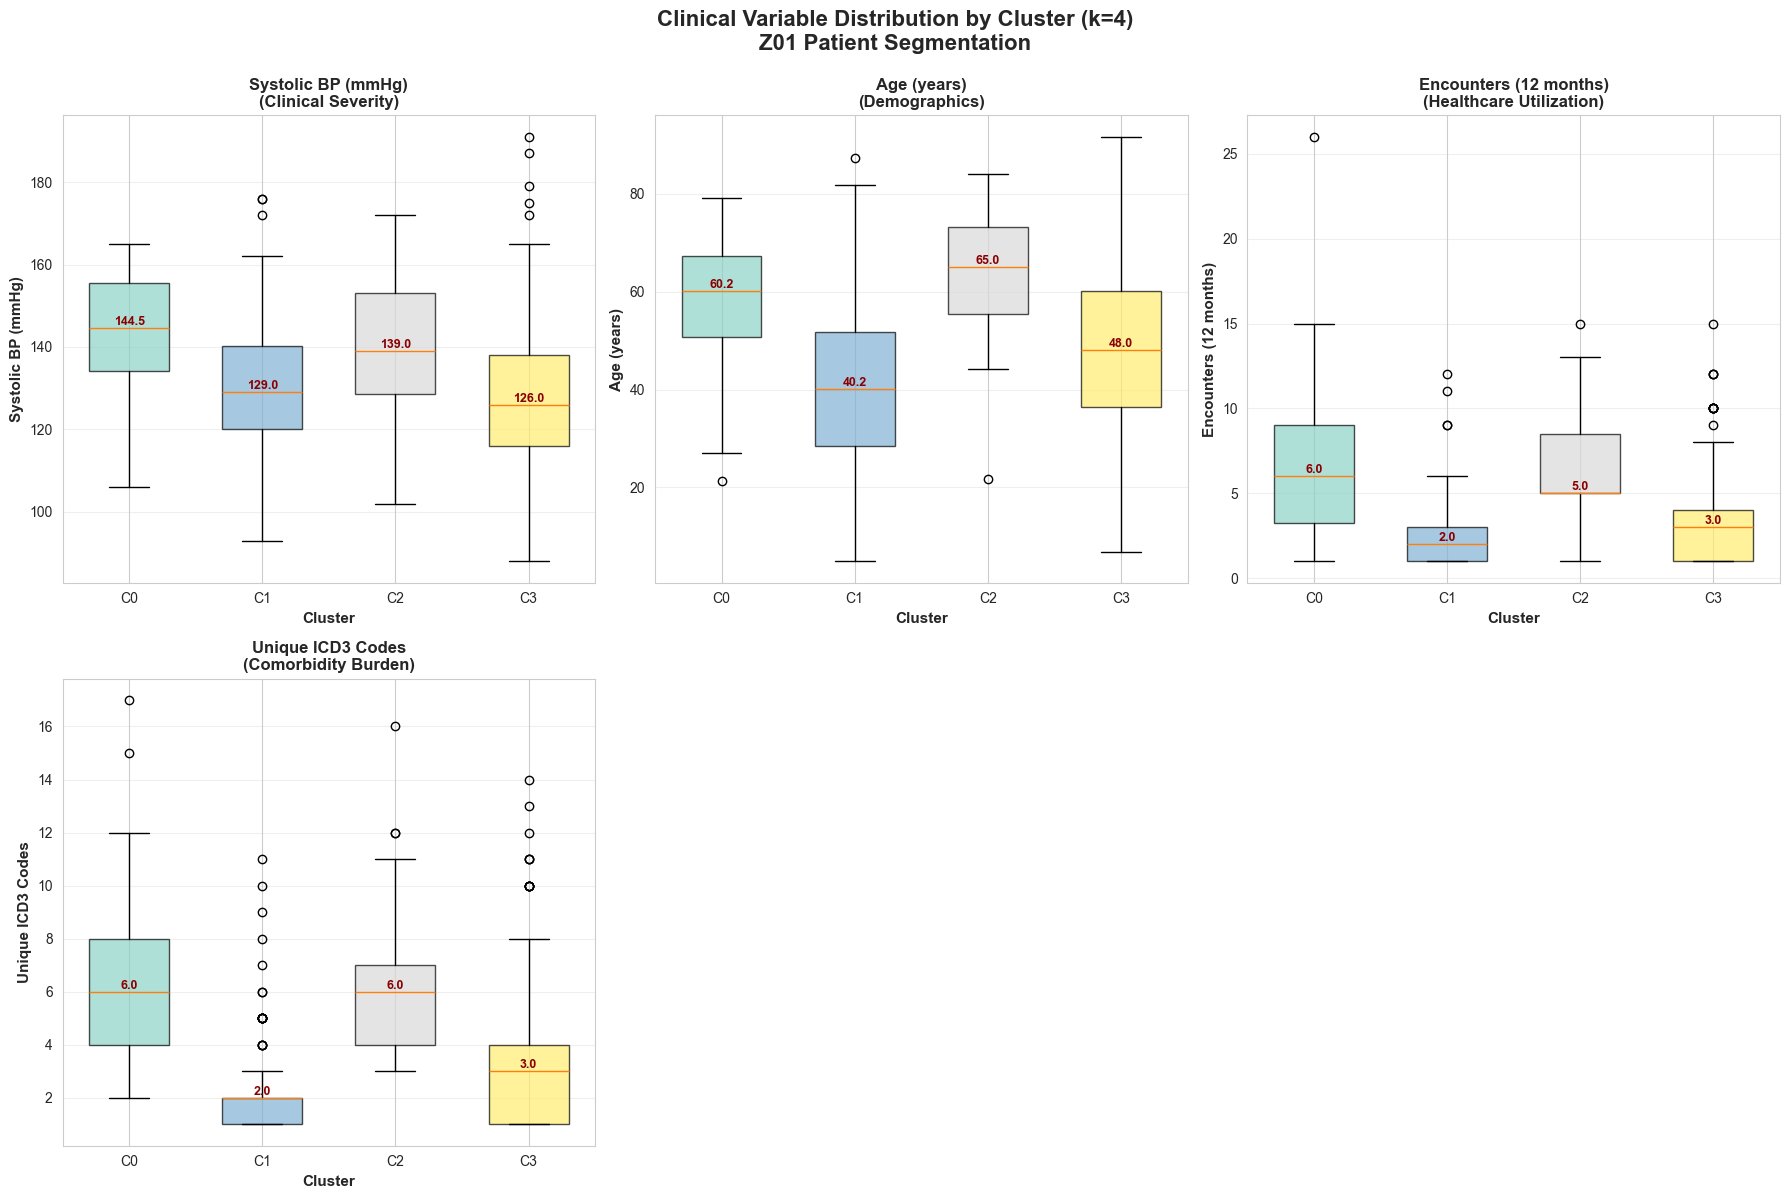

✓ Saved: outputs/visualizations/z01_clustering/clinical_boxplots_k5.png


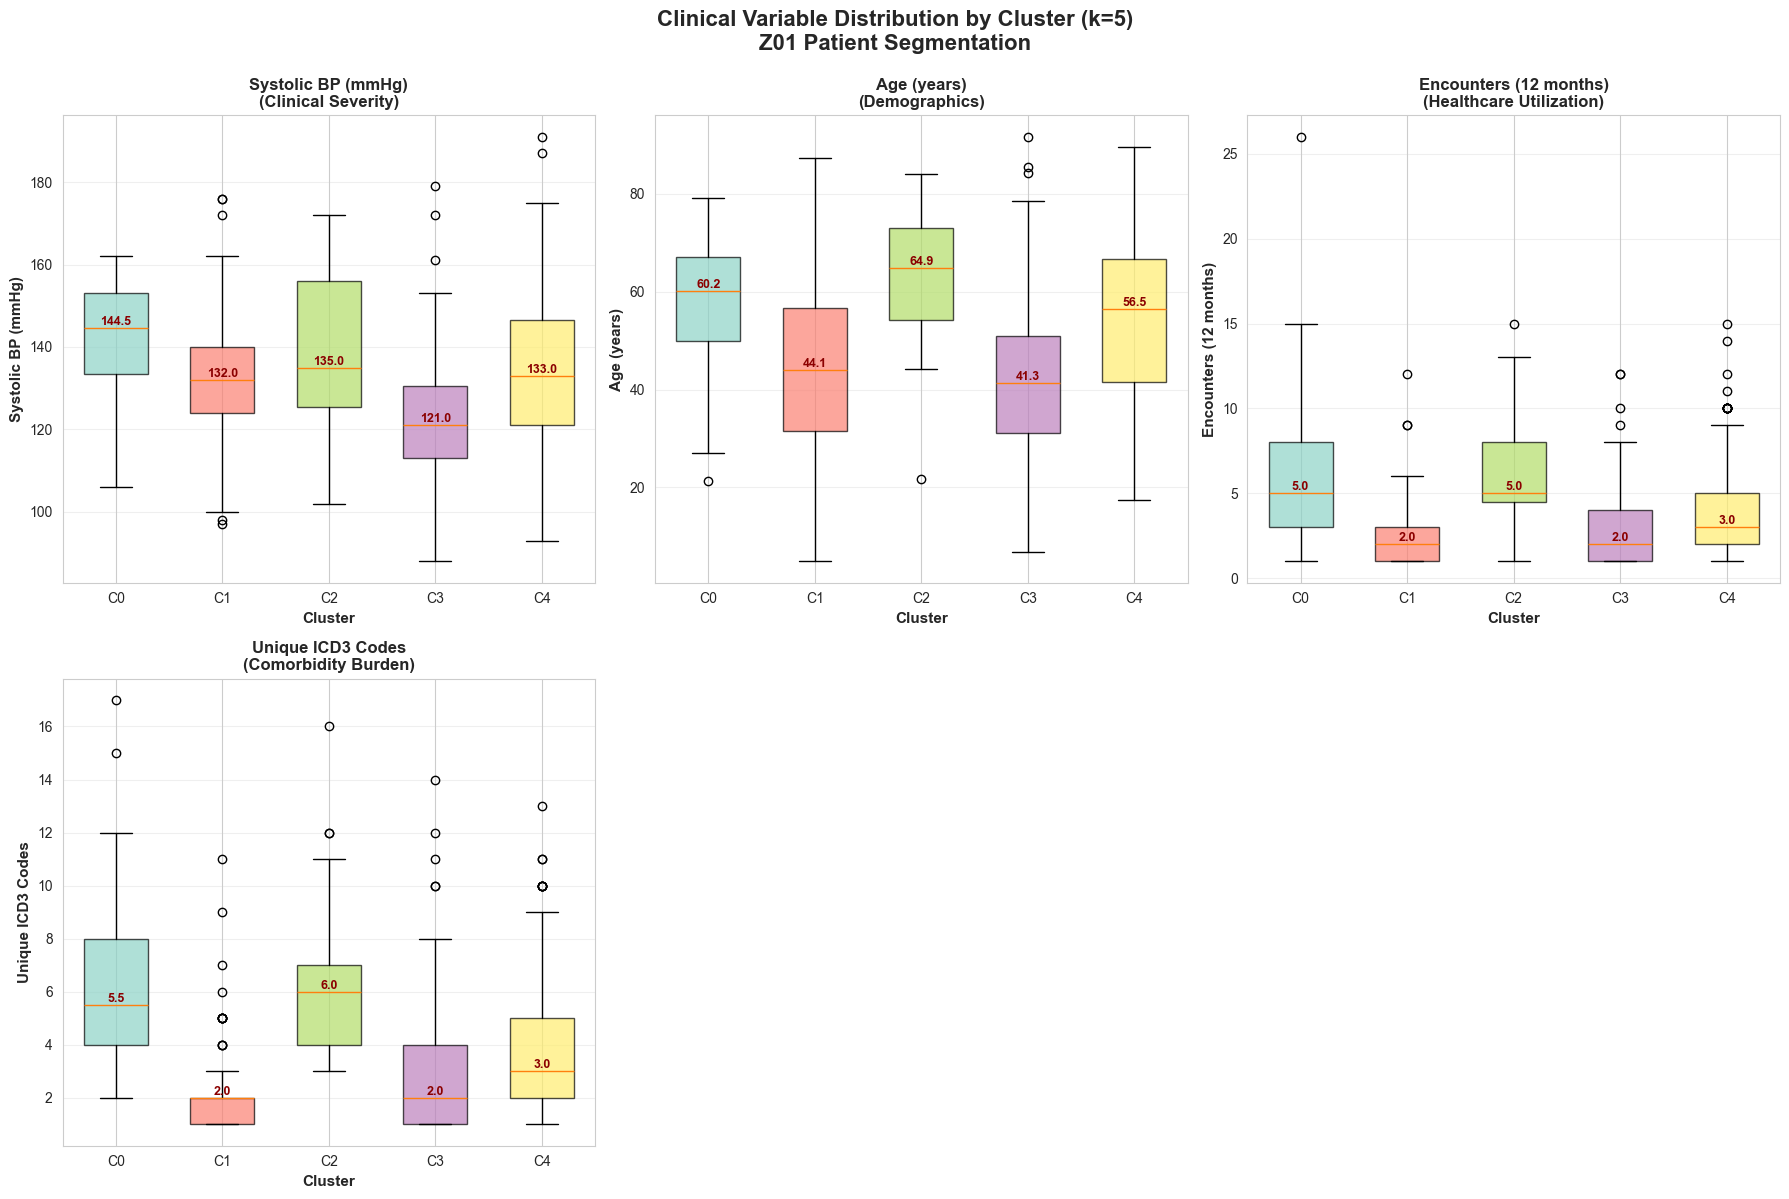

In [49]:
# Step 10b: Create clinical validation boxplots
print("Creating clinical validation boxplots...\n")

# For each k, create a comprehensive clinical comparison plot
for k in k_values:
    labels = clustering_results[k]['labels']
    
    # Create dataframe with labels
    plot_df = clustering_data_clean.copy()
    plot_df['Cluster'] = labels
    
    # Define clinical variables to plot (only those available in the data)
    desired_clinical_vars = [
        ('sbp_latest', 'Systolic BP (mmHg)', 'Clinical Severity'),
        ('bmi_latest', 'BMI (kg/m²)', 'Body Composition'),
        ('age', 'Age (years)', 'Demographics'),
        ('encounter_count_12m', 'Encounters (12 months)', 'Healthcare Utilization'),
        ('icd3_count', 'Unique ICD3 Codes', 'Comorbidity Burden')
    ]
    
    # Filter to only available variables
    clinical_vars = [(var, label, cat) for var, label, cat in desired_clinical_vars if var in plot_df.columns]
    
    # Create figure with appropriate number of subplots
    n_vars = len(clinical_vars)
    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (var, label, category) in enumerate(clinical_vars):
        ax = axes[idx]
        
        # Create boxplot
        bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in range(k)],
                        tick_labels=[f'C{i}' for i in range(k)],
                        patch_artist=True, widths=0.6)
        
        # Color boxes
        colors_bp = plt.cm.Set3(np.linspace(0, 1, k))
        for patch, color in zip(bp['boxes'], colors_bp):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
        ax.set_ylabel(label, fontsize=11, fontweight='bold')
        ax.set_title(f'{label}\n({category})', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add median values as text
        medians = [plot_df[plot_df['Cluster'] == i][var].median() for i in range(k)]
        for i, median in enumerate(medians):
            if pd.notna(median):
                ax.text(i + 1, median, f'{median:.1f}', ha='center', va='bottom',
                       fontsize=9, fontweight='bold', color='darkred')
    
    # Hide unused subplots
    for idx in range(n_vars, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Clinical Variable Distribution by Cluster (k={k})\nZ01 Patient Segmentation',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    output_path = output_dir / f"clinical_boxplots_k{k}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    plt.show()

print(f"\n{'='*60}")


In [50]:
# Step 10c: Clinical validation summary
print(f"{'='*60}")
print("Clinical Validation Summary")
print(f"{'='*60}\n")

print(f"{'k':<5} {'SBP Range':<20} {'Max Diff':<12} {'BMI Range':<20} {'Clinically Distinct':<20}")
print(f"{'-'*80}")

for k in k_values:
    profiles = clinical_profiles[k]
    
    sbp_medians = profiles['sbp_latest_median'].values
    sbp_range = f"{sbp_medians.min():.1f}-{sbp_medians.max():.1f}"
    max_sbp_diff = sbp_medians.max() - sbp_medians.min()
    
    if 'bmi_latest_median' in profiles.columns:
        bmi_medians = profiles['bmi_latest_median'].values
        bmi_range = f"{bmi_medians.min():.1f}-{bmi_medians.max():.1f}"
    else:
        bmi_range = "N/A"
    
    is_distinct = "✓" if clustering_results[k]['sbp_clinically_distinct'] else "✗"
    
    print(f"{k:<5} {sbp_range:<20} {max_sbp_diff:<12.1f} {bmi_range:<20} {is_distinct:<20}")

print(f"\nk values with clinically distinct SBP (≥10 mmHg difference):",
      [k for k in k_values if clustering_results[k]['sbp_clinically_distinct']])

print(f"\n{'='*60}")


Clinical Validation Summary

k     SBP Range            Max Diff     BMI Range            Clinically Distinct 
--------------------------------------------------------------------------------
3     127.0-146.0          19.0         23.8-31.5            ✓                   
4     126.0-144.5          18.5         25.0-31.2            ✓                   
5     121.0-144.5          23.5         24.1-32.2            ✓                   

k values with clinically distinct SBP (≥10 mmHg difference): [3, 4, 5]



## Step 11: Optimal k Selection


In [51]:
# Step 11: Select optimal k based on all criteria
print(f"{'='*60}")
print("Step 11: Optimal k Selection")
print(f"{'='*60}\n")

# Define selection criteria
print("Selection criteria:")
print("  1. Silhouette score ≥ 0.15 (preferably ≥ 0.20)")
print("  2. Stability (mean Jaccard) ≥ 0.60")
print("  3. All clusters ≥ 5% of cohort")
print("  4. SBP difference ≥ 10 mmHg (clinical distinctness)")
print("  5. Prefer smallest k that meets all criteria")
print()

# Create comprehensive comparison table
print(f"\n{'='*60}")
print("Comprehensive Evaluation Summary")
print(f"{'='*60}\n")

comparison_data = []
for k in k_values:
    result = clustering_results[k]
    
    row = {
        'k': k,
        'silhouette': result['silhouette'],
        'stability': result['stability_mean'],
        'size_ok': result['meets_size_threshold'],
        'sbp_distinct': result['sbp_clinically_distinct'],
        'min_cluster_size': min(result['cluster_sizes'].values()),
        'min_cluster_pct': (min(result['cluster_sizes'].values()) / len(clustering_data_clean)) * 100
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Check which k values meet all criteria
comparison_df['meets_silhouette_min'] = comparison_df['silhouette'] >= 0.15
comparison_df['meets_silhouette_good'] = comparison_df['silhouette'] >= 0.20
comparison_df['meets_stability'] = comparison_df['stability'] >= 0.60
comparison_df['meets_all_min'] = (comparison_df['meets_silhouette_min'] & 
                                   comparison_df['meets_stability'] & 
                                   comparison_df['size_ok'] & 
                                   comparison_df['sbp_distinct'])
comparison_df['meets_all_good'] = (comparison_df['meets_silhouette_good'] & 
                                    comparison_df['meets_stability'] & 
                                    comparison_df['size_ok'] & 
                                    comparison_df['sbp_distinct'])

# Display comparison table
print(f"{'k':<5} {'Silhouette':<12} {'Stability':<12} {'Size ≥5%':<10} {'SBP ≥10':<10} {'Meets Min':<12} {'Meets Good':<12}")
print(f"{'-'*85}")
for _, row in comparison_df.iterrows():
    k_val = int(row['k'])
    sil = row['silhouette']
    stab = row['stability']
    size = "✓" if row['size_ok'] else "✗"
    sbp = "✓" if row['sbp_distinct'] else "✗"
    meets_min = "✓" if row['meets_all_min'] else "✗"
    meets_good = "✓" if row['meets_all_good'] else "✗"
    
    print(f"{k_val:<5} {sil:<12.4f} {stab:<12.4f} {size:<10} {sbp:<10} {meets_min:<12} {meets_good:<12}")

print(f"\n{'='*60}")
print("Decision Logic:")
print(f"{'='*60}\n")

# Find k values that meet criteria
k_meets_all_good = comparison_df[comparison_df['meets_all_good']]['k'].tolist()
k_meets_all_min = comparison_df[comparison_df['meets_all_min']]['k'].tolist()

if k_meets_all_good:
    optimal_k = min(k_meets_all_good)
    print(f"✓ k values meeting ALL criteria (silhouette ≥ 0.20): {k_meets_all_good}")
    print(f"✓ RECOMMENDED k = {optimal_k} (smallest k meeting all good criteria)")
    recommendation_level = "STRONG"
elif k_meets_all_min:
    optimal_k = min(k_meets_all_min)
    print(f"⚠ No k meets all criteria with silhouette ≥ 0.20")
    print(f"✓ k values meeting minimum criteria (silhouette ≥ 0.15): {k_meets_all_min}")
    print(f"✓ RECOMMENDED k = {optimal_k} (smallest k meeting minimum criteria)")
    recommendation_level = "MODERATE"
else:
    # Fall back to best compromise
    print(f"⚠ No k meets all criteria")
    print(f"\nEvaluating best compromise...")
    
    # Score each k (higher is better)
    comparison_df['score'] = (
        comparison_df['meets_silhouette_min'].astype(int) * 2 +
        comparison_df['meets_stability'].astype(int) * 2 +
        comparison_df['size_ok'].astype(int) * 1 +
        comparison_df['sbp_distinct'].astype(int) * 1
    )
    
    # Among highest scores, pick smallest k
    max_score = comparison_df['score'].max()
    best_k_candidates = comparison_df[comparison_df['score'] == max_score]['k'].tolist()
    optimal_k = min(best_k_candidates)
    
    print(f"✓ Best compromise k = {optimal_k} (highest score: {max_score}/6, smallest k)")
    recommendation_level = "COMPROMISE"

print(f"\n{'='*60}")
print(f"FINAL RECOMMENDATION: k = {optimal_k}")
print(f"Recommendation level: {recommendation_level}")
print(f"{'='*60}\n")

# Display detailed metrics for optimal k
print(f"Detailed metrics for k = {optimal_k}:")
print(f"  Silhouette score: {clustering_results[optimal_k]['silhouette']:.4f}")
print(f"  Stability (Jaccard): {clustering_results[optimal_k]['stability_mean']:.4f}")
print(f"  Cluster size range: {min(clustering_results[optimal_k]['cluster_sizes'].values())}-{max(clustering_results[optimal_k]['cluster_sizes'].values())} patients")
print(f"  SBP clinical distinction: {'Yes' if clustering_results[optimal_k]['sbp_clinically_distinct'] else 'No'}")
print()

# Display cluster breakdown
print(f"Cluster breakdown for k = {optimal_k}:")
profiles = clinical_profiles[optimal_k]
for _, row in profiles.iterrows():
    cluster_id = int(row['cluster'])
    n = int(row['n_patients'])
    pct = row['pct_patients']
    sbp = row['sbp_latest_median']
    if 'bmi_latest_median' in row.index:
        bmi = row['bmi_latest_median']
    else:
        bmi = np.nan
    enc = row['encounter_count_12m_median']
    bmi_str = f"{bmi:.1f}" if pd.notna(bmi) else "N/A"
    print(f"  Cluster {cluster_id}: n={n:3d} ({pct:5.1f}%), SBP={sbp:.1f}, BMI={bmi_str}, Encounters={enc:.1f}")

# Store optimal k
optimal_k_selected = optimal_k

print(f"\n{'='*60}")


Step 11: Optimal k Selection

Selection criteria:
  1. Silhouette score ≥ 0.15 (preferably ≥ 0.20)
  2. Stability (mean Jaccard) ≥ 0.60
  3. All clusters ≥ 5% of cohort
  4. SBP difference ≥ 10 mmHg (clinical distinctness)
  5. Prefer smallest k that meets all criteria


Comprehensive Evaluation Summary

k     Silhouette   Stability    Size ≥5%   SBP ≥10    Meets Min    Meets Good  
-------------------------------------------------------------------------------------
3     0.1159       0.3077       ✓          ✓          ✗            ✗           
4     0.2211       0.3615       ✓          ✓          ✗            ✗           
5     0.1982       0.2973       ✓          ✓          ✗            ✗           

Decision Logic:

⚠ No k meets all criteria

Evaluating best compromise...
✓ Best compromise k = 4 (highest score: 4/6, smallest k)

FINAL RECOMMENDATION: k = 4
Recommendation level: COMPROMISE

Detailed metrics for k = 4:
  Silhouette score: 0.2211
  Stability (Jaccard): 0.3615
  Cluste

In [52]:
# Step 12a: Generate final clustering results with optimal k
print(f"{'='*60}")
print(f"Step 12: Final Clustering Results (k={optimal_k_selected})")
print(f"{'='*60}\n")

# Get final clustering results
final_model = clustering_results[optimal_k_selected]['model']
final_labels = clustering_results[optimal_k_selected]['labels']
final_medoid_indices = clustering_results[optimal_k_selected]['medoid_indices']

print(f"Final model parameters:")
print(f"  Number of clusters: {optimal_k_selected}")
print(f"  Algorithm: K-Medoids (PAM)")
print(f"  Distance metric: Gower")
print(f"  Iterations: {final_model.n_iter_}")
print(f"  Inertia: {final_model.inertia_:.4f}")
print()

# Create comprehensive results dataframe
# Start with patient IDs
final_results_df = pd.DataFrame({
    'pid': patient_ids,
    'cluster': final_labels
})

# Add all original features
for col in clustering_data_clean.columns:
    final_results_df[col] = clustering_data_clean[col].values

# Add cluster label with descriptive name (we'll name them based on clinical profiles)
print(f"\n{'='*60}")
print("Identifying Medoid Patients (Cluster Exemplars)")
print(f"{'='*60}\n")

medoid_descriptions = []
for cluster_id, medoid_idx in enumerate(final_medoid_indices):
    medoid_pid = patient_ids.iloc[medoid_idx]
    # Use clustering_data_clean for medoid data (refined features)
    medoid_data = clustering_data_clean.iloc[medoid_idx]
    # Also get from full features if available for additional info
    medoid_full = profiling_base.iloc[medoid_idx] if 'profiling_base' in locals() else medoid_data
    
    print(f"Cluster {cluster_id} Medoid:")
    print(f"  Patient ID: {medoid_pid}")
    print(f"  SBP: {medoid_data['sbp_latest']:.1f} mmHg")
    if 'dbp_latest' in medoid_data.index:
        print(f"  DBP: {medoid_data['dbp_latest']:.1f} mmHg")
    # Try to get BMI from full features, fall back to bmi_class if not available
    if 'bmi_latest' in medoid_full.index:
        print(f"  BMI: {medoid_full['bmi_latest']:.1f}")
    elif 'bmi_class' in medoid_data.index:
        print(f"  BMI Class: {medoid_data['bmi_class']}")
    print(f"  Age: {medoid_data['age']:.0f} years")
    print(f"  Encounters (12m): {medoid_data['encounter_count_12m']}")
    print(f"  ICD3 count: {medoid_data['icd3_count']}")
    print()
    
    medoid_descriptions.append({
        'cluster': cluster_id,
        'medoid_pid': medoid_pid,
        'medoid_idx': medoid_idx
    })

print(f"{'='*60}")


Step 12: Final Clustering Results (k=4)

Final model parameters:
  Number of clusters: 4
  Algorithm: K-Medoids (PAM)
  Distance metric: Gower
  Iterations: 2
  Inertia: 67.6407


Identifying Medoid Patients (Cluster Exemplars)

Cluster 0 Medoid:
  Patient ID: 4c43708e6d000fa09f267a60d9e0b125db3b3a59567e2d27ce4f37a4a70e6056
  SBP: 140.0 mmHg
  BMI: 25.5
  Age: 62 years
  Encounters (12m): 9
  ICD3 count: 6

Cluster 1 Medoid:
  Patient ID: 5689900aaf7c3238f27dd9247325b28e389c193b31a020ee97c1b59eb7a2ff6d
  SBP: 137.0 mmHg
  BMI: 24.9
  Age: 39 years
  Encounters (12m): 2
  ICD3 count: 2

Cluster 2 Medoid:
  Patient ID: 8cfc829ffb6ca1afa669abf6dafd01eb77521e45f4221b587501d3dc02577218
  SBP: 129.0 mmHg
  BMI: 30.4
  Age: 70 years
  Encounters (12m): 8
  ICD3 count: 6

Cluster 3 Medoid:
  Patient ID: 87a8d11542caaedc429e45f5d83cfb730f1d4d458825ae5698d6673c37e5029e
  SBP: 132.0 mmHg
  BMI: 29.6
  Age: 51 years
  Encounters (12m): 3
  ICD3 count: 3



In [53]:
# Step 12b: Create comprehensive cluster profiles
print(f"{'='*60}")
print("Comprehensive Cluster Profiles")
print(f"{'='*60}\n")

final_profiles = clinical_profiles[optimal_k_selected].copy()

# Add additional profile information
for cluster_id in range(optimal_k_selected):
    cluster_mask = final_labels == cluster_id
    cluster_data = clustering_data_clean[cluster_mask]
    # Use profiling_base for features not in clustering set
    cluster_full_data = profiling_base[cluster_mask] if 'profiling_base' in locals() else cluster_data
    
    # Add additional statistics
    final_profiles.loc[cluster_id, 'age_min'] = cluster_data['age'].min()
    final_profiles.loc[cluster_id, 'age_max'] = cluster_data['age'].max()
    final_profiles.loc[cluster_id, 'sbp_min'] = cluster_data['sbp_latest'].min()
    final_profiles.loc[cluster_id, 'sbp_max'] = cluster_data['sbp_latest'].max()
    
    # BMI stats - use full data if available
    if 'bmi_latest' in cluster_full_data.columns:
        final_profiles.loc[cluster_id, 'bmi_min'] = cluster_full_data['bmi_latest'].min()
        final_profiles.loc[cluster_id, 'bmi_max'] = cluster_full_data['bmi_latest'].max()
    
    # Gender distribution
    if 'sex' in cluster_data.columns:
        gender_counts = cluster_data['sex'].value_counts()
        for gender in gender_counts.index:
            final_profiles.loc[cluster_id, f'sex_{gender}_pct'] = (gender_counts[gender] / len(cluster_data)) * 100
    
    # BP stage distribution - only if available
    if 'bp_stage' in cluster_full_data.columns:
        bp_stage_counts = cluster_full_data['bp_stage'].value_counts()
        for stage in bp_stage_counts.index:
            final_profiles.loc[cluster_id, f'bp_stage_{stage}_pct'] = (bp_stage_counts[stage] / len(cluster_full_data)) * 100

# Display comprehensive profile table
print("Cluster Profiles Summary:\n")
for cluster_id in range(optimal_k_selected):
    row = final_profiles.iloc[cluster_id]
    print(f"{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Size: {int(row['n_patients'])} patients ({row['pct_patients']:.1f}% of cohort)")
    print()
    print(f"Clinical Metrics (Median ± Std):")
    print(f"  SBP: {row['sbp_latest_median']:.1f} ± {row['sbp_latest_std']:.1f} mmHg (range: {row['sbp_min']:.1f}-{row['sbp_max']:.1f})")
    if 'dbp_latest_median' in row.index:
        print(f"  DBP: {row['dbp_latest_median']:.1f} ± {row['dbp_latest_std']:.1f} mmHg")
    # BMI - check if available (may not be in clustering features)
    if 'bmi_latest_median' in row.index and pd.notna(row.get('bmi_min')):
        print(f"  BMI: {row['bmi_latest_median']:.1f} ± {row['bmi_latest_std']:.1f} (range: {row['bmi_min']:.1f}-{row['bmi_max']:.1f})")
    elif 'bmi_latest_median' in row.index:
        print(f"  BMI: {row['bmi_latest_median']:.1f} ± {row['bmi_latest_std']:.1f}")
    print(f"  Age: {row['age_median']:.0f} ± {row['age_std']:.1f} years (range: {row['age_min']:.0f}-{row['age_max']:.0f})")
    print()
    print(f"Healthcare Utilization:")
    print(f"  Encounters (12m): {row['encounter_count_12m_median']:.1f} ± {row['encounter_count_12m_std']:.1f}")
    print(f"  ICD3 codes: {row['icd3_count_median']:.1f} ± {row['icd3_count_std']:.1f}")
    print()
    print(f"Comorbidities (% with condition):")
    if 'has_I10_pct' in row.index:
        print(f"  Hypertension (I10): {row['has_I10_pct']:.1f}%")
    if 'has_E78_pct' in row.index:
        print(f"  Dyslipidemia (E78): {row['has_E78_pct']:.1f}%")
    if 'has_E11_pct' in row.index:
        print(f"  Diabetes (E11): {row['has_E11_pct']:.1f}%")
    print()

print(f"{'='*70}\n")


Comprehensive Cluster Profiles

Cluster Profiles Summary:

CLUSTER 0
Size: 46 patients (10.8% of cohort)

Clinical Metrics (Median ± Std):
  SBP: 144.5 ± 15.7 mmHg (range: 106.0-165.0)
  DBP: 88.0 ± 10.3 mmHg
  BMI: 29.1 ± 6.8 (range: 20.6-48.4)
  Age: 60 ± 13.6 years (range: 21-79)

Healthcare Utilization:
  Encounters (12m): 6.0 ± 4.4
  ICD3 codes: 6.0 ± 3.3

Comorbidities (% with condition):
  Hypertension (I10): 95.7%
  Dyslipidemia (E78): 13.0%

CLUSTER 1
Size: 120 patients (28.2% of cohort)

Clinical Metrics (Median ± Std):
  SBP: 129.0 ± 16.9 mmHg (range: 93.0-176.0)
  DBP: 84.0 ± 13.4 mmHg
  BMI: 25.0 ± 6.8 (range: 15.9-46.2)
  Age: 40 ± 18.2 years (range: 5-87)

Healthcare Utilization:
  Encounters (12m): 2.0 ± 2.0
  ICD3 codes: 2.0 ± 1.9

Comorbidities (% with condition):
  Hypertension (I10): 2.5%
  Dyslipidemia (E78): 1.7%

CLUSTER 2
Size: 39 patients (9.2% of cohort)

Clinical Metrics (Median ± Std):
  SBP: 139.0 ± 17.0 mmHg (range: 102.0-172.0)
  DBP: 86.0 ± 11.2 mmHg
  B

In [54]:
# Step 12c: Generate DATA-ANCHORED cluster names
print(f"{'='*60}")
print("DATA-ANCHORED Cluster Naming")
print(f"{'='*60}\n")

def generate_data_anchored_cluster_name(sbp, bmi, encounters, cluster_id=None, assignments_df=None):
    """
    Generate precise, data-anchored cluster name.
    Format: "[BP Level] | [BMI Category] | [Utilization Level]"
    
    For Z01, uses bmi_class mode from assignments instead of bmi_latest_median
    """
    # BP Level classification (based on ACC/AHA guidelines)
    if pd.isna(sbp) or sbp < 100:
        bp_level = "BP-Missing"
    elif sbp < 120:
        bp_level = "Normal-BP"
    elif sbp < 130:
        bp_level = "Elevated-BP"
    elif sbp < 140:
        bp_level = "Stage-1-BP"
    elif sbp < 180:
        bp_level = "Stage-2-BP"
    else:
        bp_level = "Hypertensive-Crisis"
    
    # BMI Category - use bmi_class mode from assignments (same as report generation)
    if assignments_df is not None and cluster_id is not None:
        cluster_assignments = assignments_df[assignments_df['cluster'] == cluster_id]
        if len(cluster_assignments) > 0 and 'bmi_class' in cluster_assignments.columns:
            bmi_class_mode = cluster_assignments['bmi_class'].mode()
            if len(bmi_class_mode) > 0:
                bmi_class_val = bmi_class_mode.iloc[0]
                bmi_map = {
                    'Normal': 'Normal-Wt',
                    'Overweight': 'Overweight',
                    'Obesity I': 'Obese-I',
                    'Obesity II+': 'Obese-II+',
                    'Missing': 'BMI-Unknown'
                }
                bmi_cat = bmi_map.get(str(bmi_class_val), 'BMI-Unknown')
            else:
                bmi_cat = "BMI-Unknown"
        else:
            bmi_cat = "BMI-Unknown"
    else:
        # Fallback to numeric BMI if bmi_class not available
        if pd.isna(bmi):
            bmi_cat = "BMI-Unknown"
        elif bmi < 18.5:
            bmi_cat = "Underweight"
        elif bmi < 25:
            bmi_cat = "Normal-Wt"
        elif bmi < 30:
            bmi_cat = "Overweight"
        elif bmi < 35:
            bmi_cat = "Obese-I"
        elif bmi < 40:
            bmi_cat = "Obese-II"
        else:
            bmi_cat = "Obese-III"
    
    # Utilization Level (based on encounter count distribution)
    if pd.isna(encounters):
        util_level = "Util-Unknown"
    elif encounters <= 2:
        util_level = "Low-Util"
    elif encounters <= 5:
        util_level = "Med-Util"
    elif encounters <= 8:
        util_level = "High-Util"
    else:
        util_level = "VHigh-Util"
    
    # Construct data-anchored name
    name = f"{bp_level} | {bmi_cat} | {util_level}"
    
    return name

# Generate names for each cluster
cluster_names = {}
print("Generated Data-Anchored Cluster Names:\n")
print(f"{'Cluster':<10} {'Data-Anchored Name':<50} {'N':<8} {'%':<6}")
print(f"{'-'*80}")

# Get assignments dataframe for bmi_class mode
# Use final_results_df which contains cluster assignments with bmi_class
assignments_df = final_results_df.copy() if 'final_results_df' in locals() else None

for cluster_id in range(optimal_k_selected):
    row = final_profiles.iloc[cluster_id]
    
    # Get key metrics
    sbp = row['sbp_latest_median']
    # Get BMI - may be in different columns (but we'll use bmi_class mode instead)
    bmi = row.get('bmi_latest_median', row.get('bmi_median', np.nan))
    encounters = row['encounter_count_12m_median']
    
    # Generate name using bmi_class mode from assignments
    name = generate_data_anchored_cluster_name(sbp, bmi, encounters, cluster_id, assignments_df)
    cluster_names[cluster_id] = name
    
    # Display
    print(f"{cluster_id:<10} {name:<50} {int(row['n_patients']):<8} {row['pct_patients']:<6.1f}%")

# Add names to final_profiles
final_profiles['cluster_name'] = final_profiles['cluster'].map(cluster_names)

print(f"\n✓ Data-anchored names generated for {optimal_k_selected} clusters")
print(f"✓ Names added to final_profiles DataFrame")
print(f"\nNaming convention: [BP Level] | [BMI Category] | [Utilization Level]")
print(f"  - BP Level: Based on ACC/AHA guidelines (Normal/Elevated/Stage-1/Stage-2)")
print(f"  - BMI Category: Based on WHO classifications (Normal-Wt/Overweight/Obese-I/II/III)")
print(f"  - Utilization: Based on 12-month encounters (Low/Med/High/VHigh)")
print()


DATA-ANCHORED Cluster Naming

Generated Data-Anchored Cluster Names:

Cluster    Data-Anchored Name                                 N        %     
--------------------------------------------------------------------------------
0          Stage-2-BP | Overweight | High-Util                46       10.8  %
1          Elevated-BP | Normal-Wt | Low-Util                 120      28.2  %
2          Stage-1-BP | Obese-I | Med-Util                    39       9.2   %
3          Elevated-BP | Overweight | Med-Util                220      51.8  %

✓ Data-anchored names generated for 4 clusters
✓ Names added to final_profiles DataFrame

Naming convention: [BP Level] | [BMI Category] | [Utilization Level]
  - BP Level: Based on ACC/AHA guidelines (Normal/Elevated/Stage-1/Stage-2)
  - BMI Category: Based on WHO classifications (Normal-Wt/Overweight/Obese-I/II/III)
  - Utilization: Based on 12-month encounters (Low/Med/High/VHigh)



In [55]:
# Step 12d: Save clustering results and profiles to CSV
print(f"{'='*60}")
print("Saving Results to Files")
print(f"{'='*60}\n")

# Create output directory for data
output_data_dir = Path("outputs/data")
output_data_dir.mkdir(parents=True, exist_ok=True)

# Save cluster assignments
assignments_path = output_data_dir / "z01_cluster_assignments.csv"
final_results_df.to_csv(assignments_path, index=False)
print(f"✓ Saved cluster assignments: {assignments_path}")
print(f"  Shape: {final_results_df.shape}")
print(f"  Columns: {list(final_results_df.columns)}")

# Save cluster profiles
profiles_path = output_data_dir / "z01_cluster_profiles.csv"
final_profiles.to_csv(profiles_path, index=False)
print(f"\n✓ Saved cluster profiles: {profiles_path}")
print(f"  Shape: {final_profiles.shape}")

# Save medoid information
medoids_df = pd.DataFrame(medoid_descriptions)
medoids_path = output_data_dir / "z01_cluster_medoids.csv"
medoids_df.to_csv(medoids_path, index=False)
print(f"\n✓ Saved medoid information: {medoids_path}")

# Save evaluation metrics summary
eval_summary = {
    'optimal_k': optimal_k_selected,
    'silhouette_score': clustering_results[optimal_k_selected]['silhouette'],
    'stability_jaccard_mean': clustering_results[optimal_k_selected]['stability_mean'],
    'n_patients': len(final_results_df),
    'recommendation_level': recommendation_level
}
eval_df = pd.DataFrame([eval_summary])
eval_path = output_data_dir / "z01_clustering_evaluation.csv"
eval_df.to_csv(eval_path, index=False)
print(f"\n✓ Saved evaluation metrics: {eval_path}")

print(f"\n{'='*60}")


Saving Results to Files

✓ Saved cluster assignments: outputs/data/z01_cluster_assignments.csv
  Shape: (425, 11)
  Columns: ['pid', 'cluster', 'sbp_latest', 'bmi_class', 'encounter_count_12m', 'age', 'sex', 'icd3_count', 'has_I10', 'has_E78', 'bmi_missing']

✓ Saved cluster profiles: outputs/data/z01_cluster_profiles.csv
  Shape: (4, 32)

✓ Saved medoid information: outputs/data/z01_cluster_medoids.csv

✓ Saved evaluation metrics: outputs/data/z01_clustering_evaluation.csv



## Step 13: Final Visualizations


Step 13: Final Visualizations

Creating final visualizations...

✓ Saved: outputs/visualizations/z01_clustering/final_cluster_sizes_k4.png


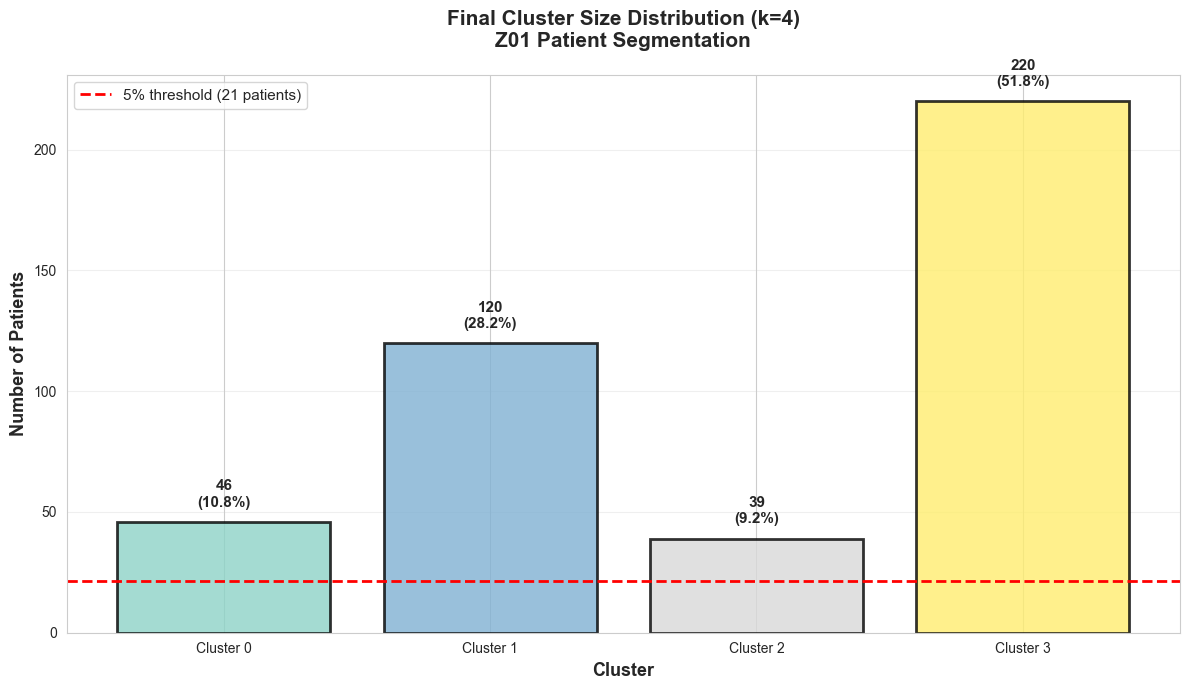

In [56]:
# Step 13a: Cluster size distribution
print(f"{'='*60}")
print("Step 13: Final Visualizations")
print(f"{'='*60}\n")

print("Creating final visualizations...\n")

# Visualization 1: Cluster size distribution
fig, ax = plt.subplots(figsize=(12, 7))

cluster_sizes = [clustering_results[optimal_k_selected]['cluster_sizes'][i] 
                 for i in range(optimal_k_selected)]
cluster_labels = [f'Cluster {i}' for i in range(optimal_k_selected)]
cluster_pcts = [(size / len(final_results_df)) * 100 for size in cluster_sizes]

colors_bar = plt.cm.Set3(np.linspace(0, 1, optimal_k_selected))
bars = ax.bar(cluster_labels, cluster_sizes, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, size, pct) in enumerate(zip(bars, cluster_sizes, cluster_pcts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{size}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add 5% threshold line
threshold_line = 0.05 * len(final_results_df)
ax.axhline(y=threshold_line, color='red', linestyle='--', linewidth=2, 
           label=f'5% threshold ({int(threshold_line)} patients)')

ax.set_xlabel('Cluster', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_title(f'Final Cluster Size Distribution (k={optimal_k_selected})\nZ01 Patient Segmentation',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
output_path = output_dir / f"final_cluster_sizes_k{optimal_k_selected}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print()


Creating clinical comparison heatmap...

Heatmap features available: 8/9
✓ Saved: outputs/visualizations/z01_clustering/clinical_profile_heatmap_k4.png


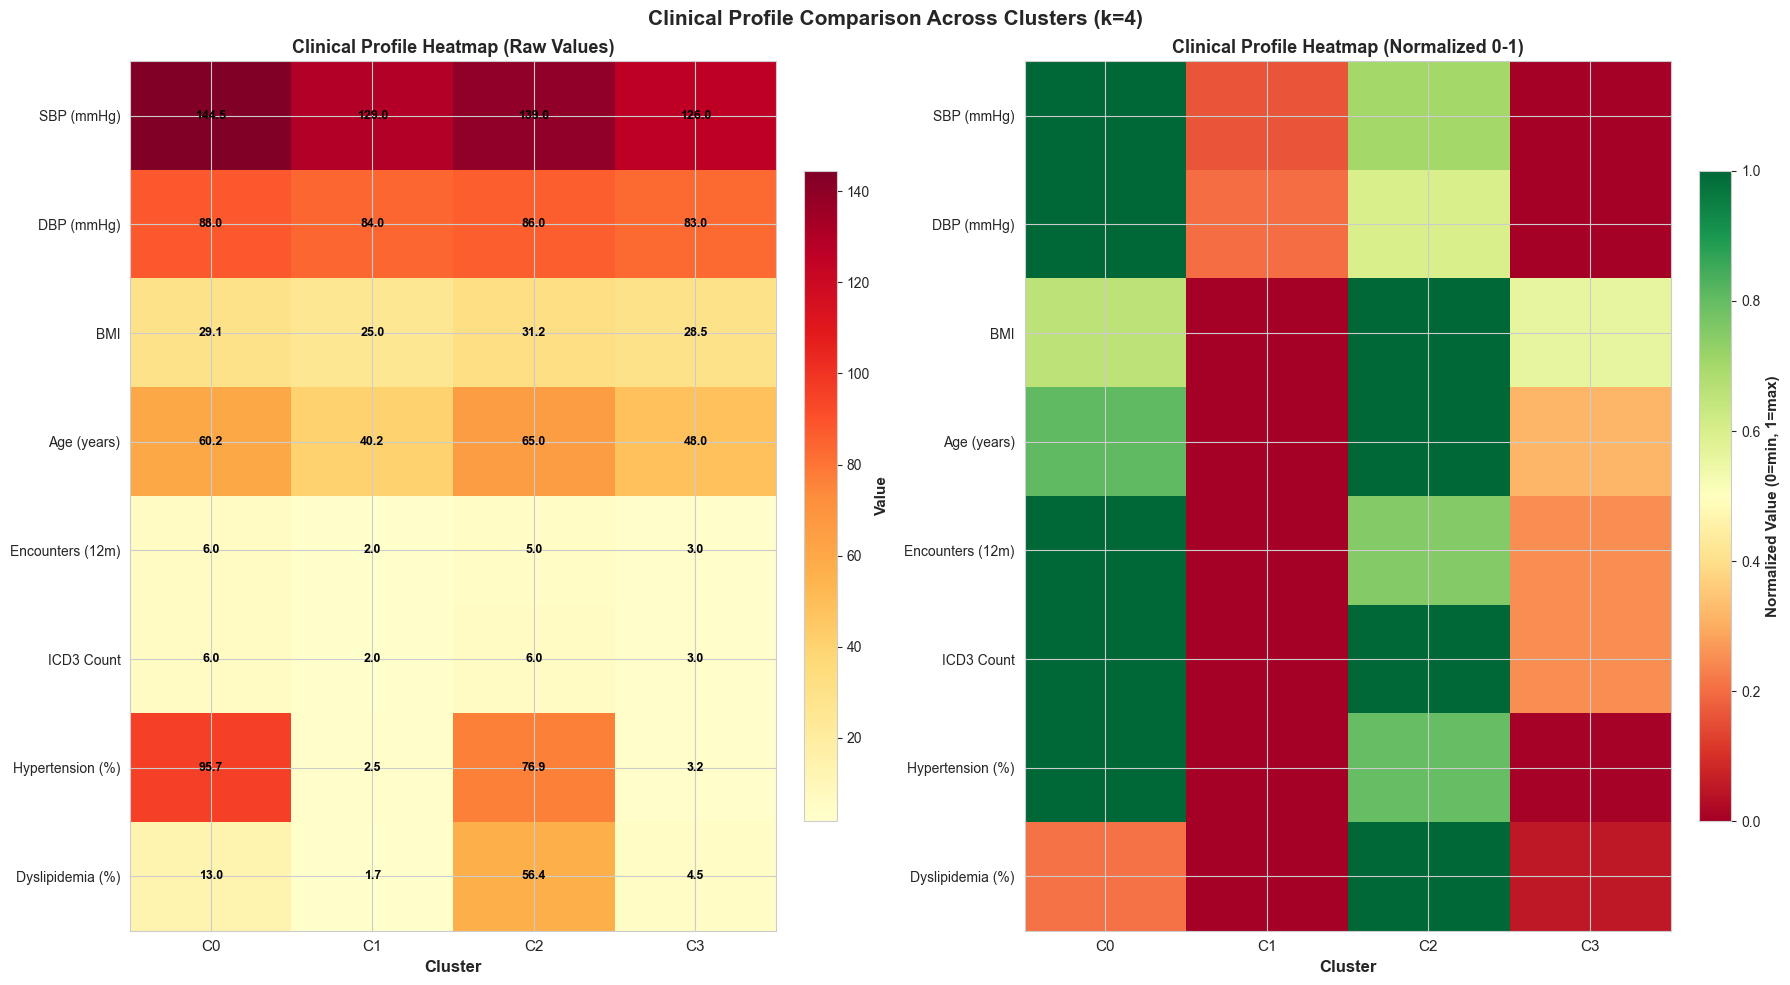

In [57]:
# Step 13b: Clinical comparison heatmap
print("Creating clinical comparison heatmap...\n")

# Prepare data for heatmap (only features that exist in final_profiles)
desired_heatmap_features = [
    ('sbp_latest_median', 'SBP (mmHg)'),
    ('dbp_latest_median', 'DBP (mmHg)'),
    ('bmi_latest_median', 'BMI'),
    ('age_median', 'Age (years)'),
    ('encounter_count_12m_median', 'Encounters (12m)'),
    ('icd3_count_median', 'ICD3 Count'),
    ('has_I10_pct', 'Hypertension (%)'),
    ('has_E78_pct', 'Dyslipidemia (%)'),
    ('has_E11_pct', 'Diabetes (%)')
]

# Filter to only available features
available_profile_cols = final_profiles.columns.tolist()
heatmap_features = []
heatmap_labels = []
for feat, label in desired_heatmap_features:
    if feat in available_profile_cols:
        heatmap_features.append(feat)
        heatmap_labels.append(label)

print(f"Heatmap features available: {len(heatmap_features)}/{len(desired_heatmap_features)}")

# Extract values for each cluster
heatmap_data = []
for cluster_id in range(optimal_k_selected):
    row_data = []
    for feat in heatmap_features:
        value = final_profiles.loc[cluster_id, feat]
        row_data.append(value)
    heatmap_data.append(row_data)

heatmap_array = np.array(heatmap_data).T  # Transpose so features are rows

# Normalize each feature to 0-1 for better visualization
heatmap_normalized = heatmap_array.copy()
for i in range(len(heatmap_normalized)):
    min_val = heatmap_normalized[i].min()
    max_val = heatmap_normalized[i].max()
    if max_val > min_val:
        heatmap_normalized[i] = (heatmap_normalized[i] - min_val) / (max_val - min_val)

# Create heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Raw values heatmap
im1 = ax1.imshow(heatmap_array, cmap='YlOrRd', aspect='auto')
ax1.set_xticks(np.arange(optimal_k_selected))
ax1.set_yticks(np.arange(len(heatmap_labels)))
ax1.set_xticklabels([f'C{i}' for i in range(optimal_k_selected)], fontsize=11)
ax1.set_yticklabels(heatmap_labels, fontsize=10)
ax1.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax1.set_title('Clinical Profile Heatmap (Raw Values)', fontsize=13, fontweight='bold')

# Add value annotations
for i in range(len(heatmap_labels)):
    for j in range(optimal_k_selected):
        text = ax1.text(j, i, f'{heatmap_array[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Value', fontsize=11, fontweight='bold')

# Normalized heatmap
im2 = ax2.imshow(heatmap_normalized, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax2.set_xticks(np.arange(optimal_k_selected))
ax2.set_yticks(np.arange(len(heatmap_labels)))
ax2.set_xticklabels([f'C{i}' for i in range(optimal_k_selected)], fontsize=11)
ax2.set_yticklabels(heatmap_labels, fontsize=10)
ax2.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax2.set_title('Clinical Profile Heatmap (Normalized 0-1)', fontsize=13, fontweight='bold')

cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('Normalized Value (0=min, 1=max)', fontsize=11, fontweight='bold')

plt.suptitle(f'Clinical Profile Comparison Across Clusters (k={optimal_k_selected})',
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()

output_path = output_dir / f"clinical_profile_heatmap_k{optimal_k_selected}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print()


Creating medoid patient profiles...

Plotting 4 metrics

✓ Saved: outputs/visualizations/z01_clustering/medoid_profiles_k4.png


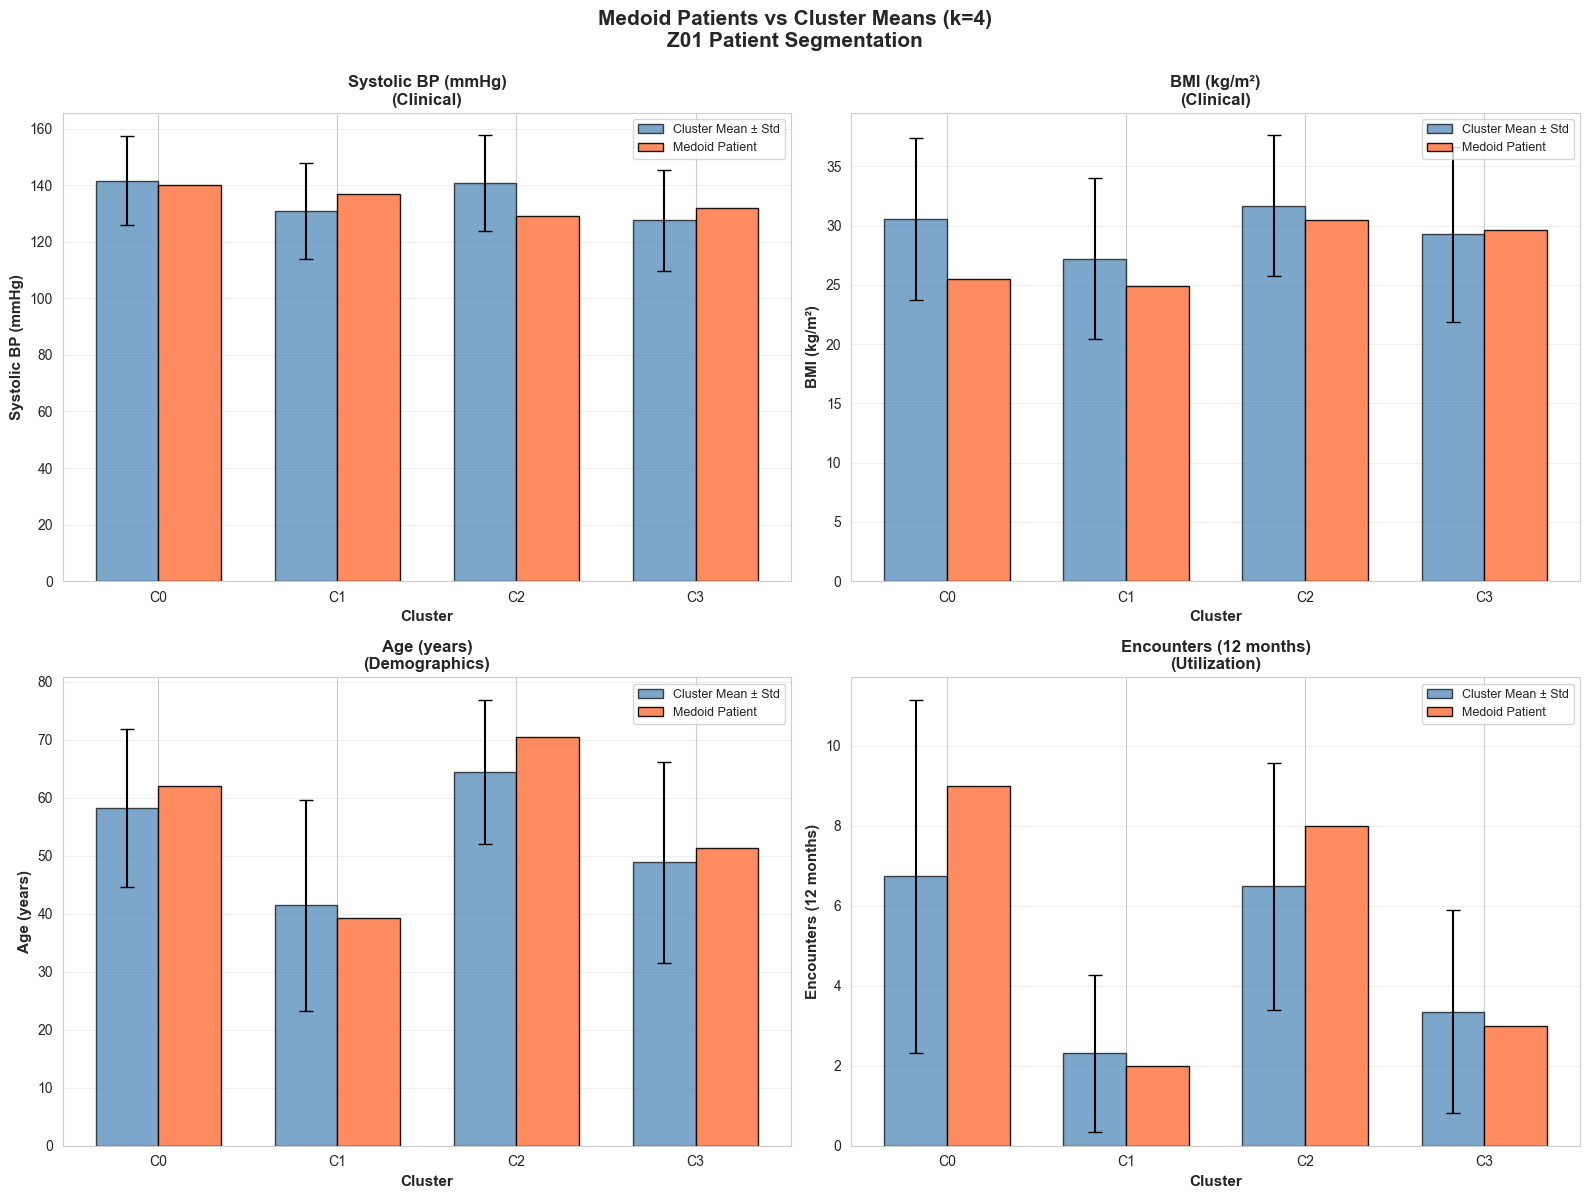

In [58]:
# Step 13c: Medoid patient profiles visualization
print("Creating medoid patient profiles...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Key metrics to compare - filter to available metrics
desired_metrics = [
    ('sbp_latest', 'Systolic BP (mmHg)', 'Clinical'),
    ('bmi_latest', 'BMI (kg/m²)', 'Clinical'),
    ('age', 'Age (years)', 'Demographics'),
    ('encounter_count_12m', 'Encounters (12 months)', 'Utilization')
]

# Filter to only metrics that are available
medoid_metrics = []
for metric, label, category in desired_metrics:
    # Check if metric is in clustering features or profiling base
    if metric in clustering_data_clean.columns:
        medoid_metrics.append((metric, label, category, clustering_data_clean))
    elif 'profiling_base' in locals() and metric in profiling_base.columns:
        medoid_metrics.append((metric, label, category, profiling_base))
    else:
        print(f"⚠ Skipping {label} - not available in data")

print(f"Plotting {len(medoid_metrics)} metrics\n")

for idx, (metric, label, category, data_source) in enumerate(medoid_metrics):
    ax = axes[idx]
    
    # Get medoid values and cluster means
    medoid_values = []
    cluster_means = []
    cluster_stds = []
    
    for cluster_id in range(optimal_k_selected):
        medoid_idx = final_medoid_indices[cluster_id]
        medoid_val = data_source.iloc[medoid_idx][metric]
        medoid_values.append(medoid_val)
        
        cluster_mask = final_labels == cluster_id
        cluster_data = data_source[cluster_mask][metric]
        cluster_means.append(cluster_data.mean())
        cluster_stds.append(cluster_data.std())
    
    x = np.arange(optimal_k_selected)
    width = 0.35
    
    # Plot cluster means with error bars
    bars1 = ax.bar(x - width/2, cluster_means, width, yerr=cluster_stds,
                   label='Cluster Mean ± Std', alpha=0.7, capsize=5,
                   color='steelblue', edgecolor='black')
    
    # Plot medoid values
    bars2 = ax.bar(x + width/2, medoid_values, width,
                   label='Medoid Patient', alpha=0.9,
                   color='coral', edgecolor='black')
    
    ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_ylabel(label, fontsize=11, fontweight='bold')
    ax.set_title(f'{label}\n({category})', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'C{i}' for i in range(optimal_k_selected)])
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused subplots if we have fewer than 4 metrics
for idx in range(len(medoid_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Medoid Patients vs Cluster Means (k={optimal_k_selected})\nZ01 Patient Segmentation',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

output_path = output_dir / f"medoid_profiles_k{optimal_k_selected}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print()


Creating evaluation metrics dashboard...

✓ Saved: outputs/visualizations/z01_clustering/evaluation_metrics_dashboard.png


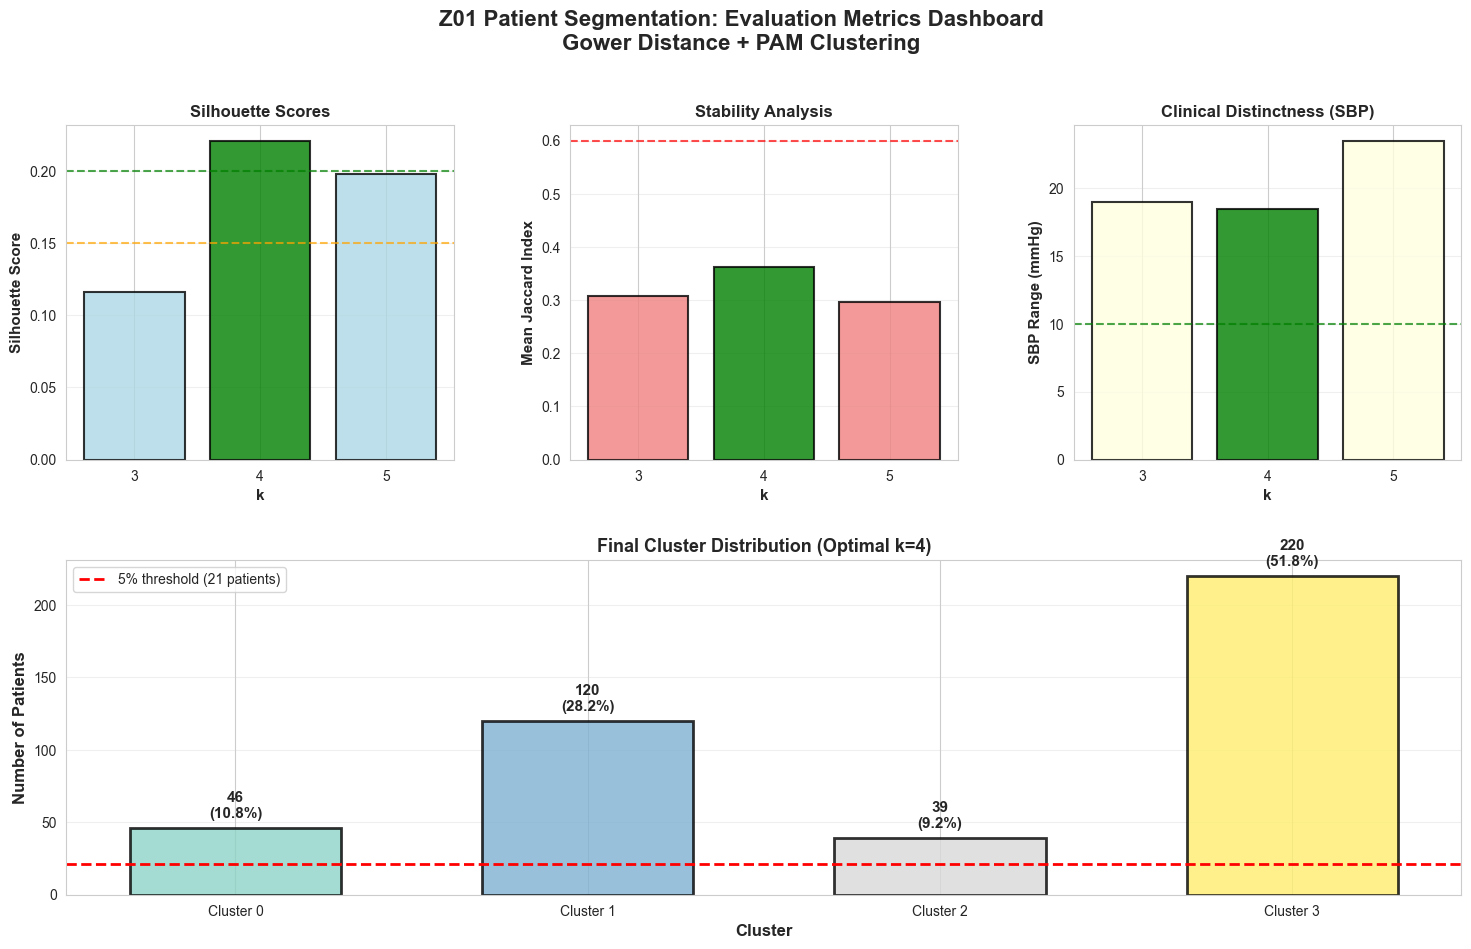


Z01 Patient Segmentation Analysis Complete!

Summary:
  Optimal k: 4
  Total patients: 425
  Silhouette score: 0.2211
  Stability (Jaccard): 0.3615
  Output files saved to: outputs/data/
  Visualizations saved to: outputs/visualizations/z01_clustering/



In [59]:
# Step 13d: Evaluation metrics dashboard
print("Creating evaluation metrics dashboard...\n")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Silhouette scores across k
ax1 = fig.add_subplot(gs[0, 0])
silhouette_scores = [clustering_results[k]['silhouette'] for k in k_values]
colors_sil = ['green' if k == optimal_k_selected else 'lightblue' for k in k_values]
ax1.bar(k_values, silhouette_scores, color=colors_sil, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(y=0.15, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=0.20, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('k', fontsize=11, fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
ax1.set_title('Silhouette Scores', fontsize=12, fontweight='bold')
ax1.set_xticks(k_values)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Stability (Jaccard) across k
ax2 = fig.add_subplot(gs[0, 1])
stability_scores = [clustering_results[k]['stability_mean'] for k in k_values]
colors_stab = ['green' if k == optimal_k_selected else 'lightcoral' for k in k_values]
ax2.bar(k_values, stability_scores, color=colors_stab, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0.60, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('k', fontsize=11, fontweight='bold')
ax2.set_ylabel('Mean Jaccard Index', fontsize=11, fontweight='bold')
ax2.set_title('Stability Analysis', fontsize=12, fontweight='bold')
ax2.set_xticks(k_values)
ax2.grid(True, alpha=0.3, axis='y')

# 3. SBP range by k
ax3 = fig.add_subplot(gs[0, 2])
sbp_ranges = []
for k in k_values:
    profiles = clinical_profiles[k]
    sbp_medians = profiles['sbp_latest_median'].values
    sbp_range = sbp_medians.max() - sbp_medians.min()
    sbp_ranges.append(sbp_range)
colors_sbp = ['green' if k == optimal_k_selected else 'lightyellow' for k in k_values]
ax3.bar(k_values, sbp_ranges, color=colors_sbp, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.axhline(y=10, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('k', fontsize=11, fontweight='bold')
ax3.set_ylabel('SBP Range (mmHg)', fontsize=11, fontweight='bold')
ax3.set_title('Clinical Distinctness (SBP)', fontsize=12, fontweight='bold')
ax3.set_xticks(k_values)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Cluster sizes for optimal k
ax4 = fig.add_subplot(gs[1, :])
cluster_sizes_opt = [clustering_results[optimal_k_selected]['cluster_sizes'][i] 
                     for i in range(optimal_k_selected)]
cluster_pcts_opt = [(size / len(final_results_df)) * 100 for size in cluster_sizes_opt]

x_pos = np.arange(optimal_k_selected)
colors_size = plt.cm.Set3(np.linspace(0, 1, optimal_k_selected))
bars = ax4.bar(x_pos, cluster_sizes_opt, color=colors_size, alpha=0.8, 
              edgecolor='black', linewidth=2, width=0.6)

# Add labels
for i, (bar, size, pct) in enumerate(zip(bars, cluster_sizes_opt, cluster_pcts_opt)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{size}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add threshold line
threshold_line = 0.05 * len(final_results_df)
ax4.axhline(y=threshold_line, color='red', linestyle='--', linewidth=2, 
           label=f'5% threshold ({int(threshold_line)} patients)')

ax4.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax4.set_title(f'Final Cluster Distribution (Optimal k={optimal_k_selected})', 
             fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'Cluster {i}' for i in range(optimal_k_selected)])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Z01 Patient Segmentation: Evaluation Metrics Dashboard\nGower Distance + PAM Clustering',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

output_path = output_dir / "evaluation_metrics_dashboard.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")
print("Z01 Patient Segmentation Analysis Complete!")
print(f"{'='*60}\n")
print(f"Summary:")
print(f"  Optimal k: {optimal_k_selected}")
print(f"  Total patients: {len(final_results_df):,}")
print(f"  Silhouette score: {clustering_results[optimal_k_selected]['silhouette']:.4f}")
print(f"  Stability (Jaccard): {clustering_results[optimal_k_selected]['stability_mean']:.4f}")
print(f"  Output files saved to: outputs/data/")
print(f"  Visualizations saved to: outputs/visualizations/z01_clustering/")
print(f"\n{'='*60}")


## Step 14: PCA Visualization with Beautiful Colors


Step 14: PCA Visualization with Beautiful Colors

✓ No missing values in PCA data

PCA Results:
  PC1 explains: 36.6% of variance
  PC2 explains: 18.0% of variance
  Total variance explained: 54.6%


✓ Saved beautiful PCA visualization: outputs/visualizations/z01_clustering/pca_visualization_beautiful_k4.png


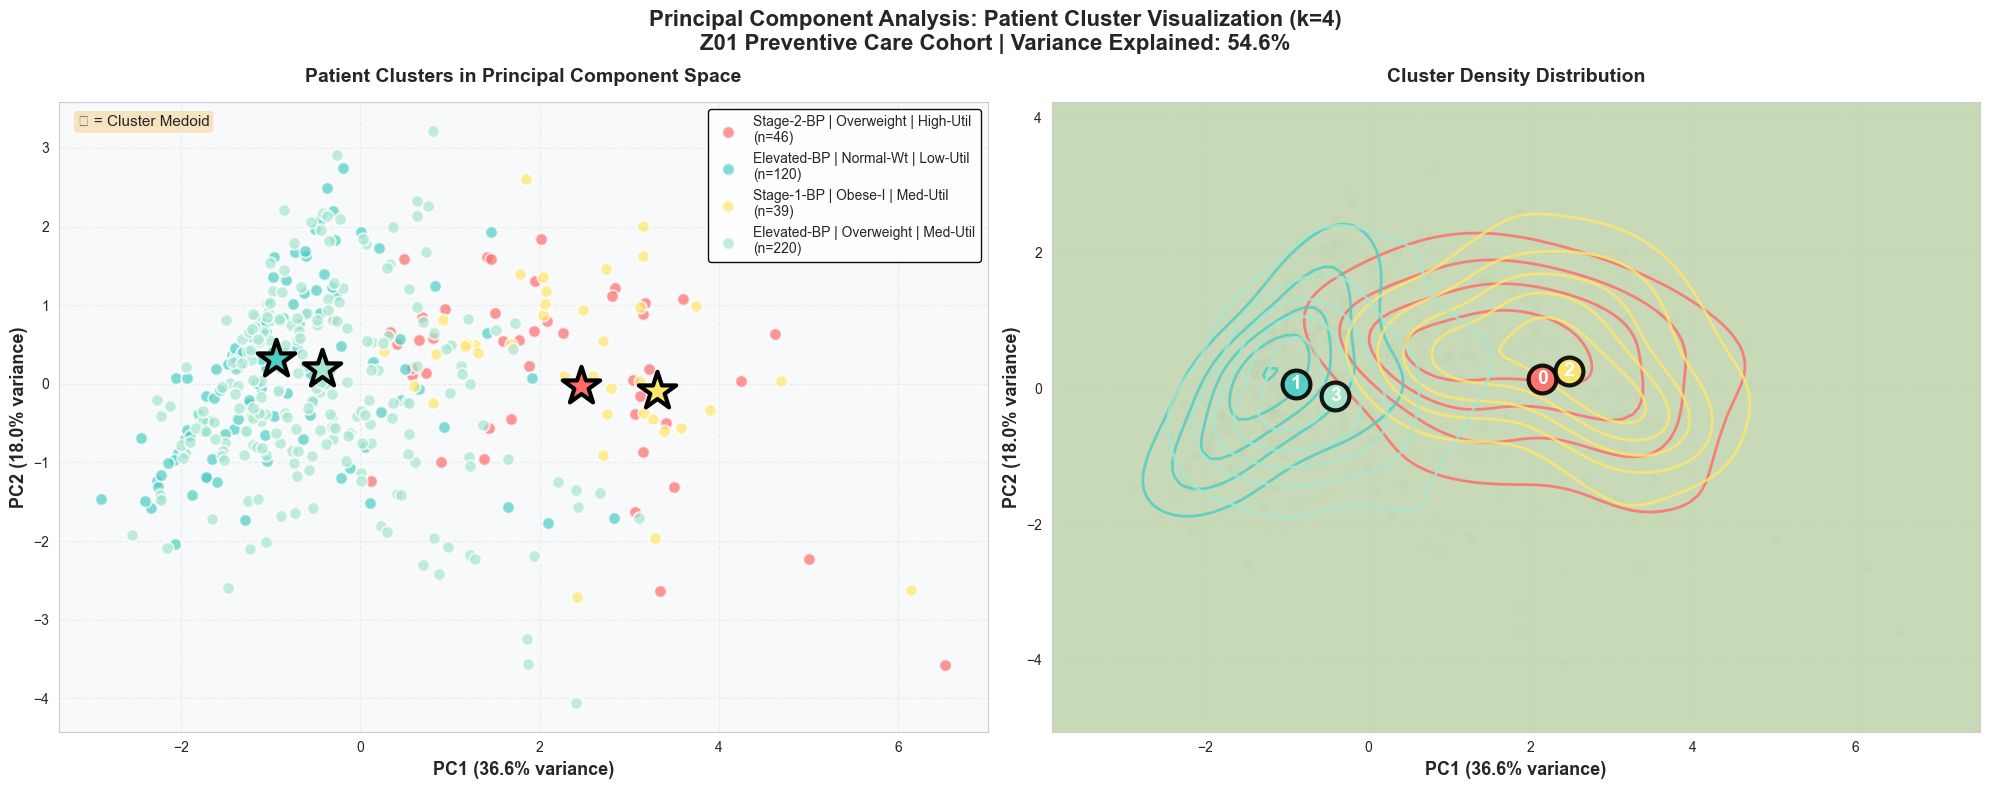


PCA Visualization Complete!

Visual Summary:
  • Left plot: Individual patients colored by cluster
  • Right plot: Cluster density distributions with contours
  • Stars (★): Cluster medoids (representative patients)
  • Colors: Distinct, vibrant palette for easy identification

Key Insights:
  • Total patients: 425
  • Number of clusters: 4
  • Variance captured by 2D projection: 54.6%



In [60]:
# Step 14: Beautiful PCA Visualization with Distinct Colors
print(f"{'='*60}")
print("Step 14: PCA Visualization with Beautiful Colors")
print(f"{'='*60}\n")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

# Prepare numeric data for PCA
numeric_cols = clustering_data_clean.select_dtypes(include=[np.number]).columns
pca_data = clustering_data_clean[numeric_cols].copy()

# Handle missing values for PCA (PCA doesn't accept NaN)
# Note: This is ONLY for visualization - we preserved NaN in actual clustering
n_missing_before = pca_data.isnull().sum().sum()
if n_missing_before > 0:
    print(f"⚠ Found {n_missing_before} missing values in PCA data")
    print(f"  Imputing with median for visualization only...\n")
    
    # Impute with median for each numeric column
    for col in pca_data.columns:
        if pca_data[col].isnull().sum() > 0:
            median_val = pca_data[col].median()
            n_missing = pca_data[col].isnull().sum()
            pca_data[col].fillna(median_val, inplace=True)
            print(f"  - {col}: filled {n_missing} missing values with median {median_val:.2f}")
    
    print(f"\n✓ PCA data ready (missing values imputed for visualization only)\n")
else:
    print(f"✓ No missing values in PCA data\n")

# Standardize before PCA
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

# Apply PCA
pca = PCA(n_components=2, random_state=RANDOM_SEED)
pca_coords = pca.fit_transform(pca_data_scaled)

print(f"PCA Results:")
print(f"  PC1 explains: {pca.explained_variance_ratio_[0]*100:.1f}% of variance")
print(f"  PC2 explains: {pca.explained_variance_ratio_[1]*100:.1f}% of variance")
print(f"  Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%\n")

# Create beautiful visualization with distinct colors
fig = plt.figure(figsize=(20, 8))

# Define beautiful color palette - vibrant and distinct colors
beautiful_colors = [
    '#FF6B6B',  # Coral Red
    '#4ECDC4',  # Turquoise
    '#FFE66D',  # Yellow
    '#A8E6CF',  # Mint Green
    '#FF8B94',  # Pink
    '#C7CEEA',  # Lavender
    '#FFDAB9',  # Peach
]

# Use colors based on optimal_k
cluster_colors = beautiful_colors[:optimal_k_selected]

# Left plot: Scatter plot with beautiful colors
ax1 = plt.subplot(1, 2, 1)

# Plot each cluster with its beautiful color
for cluster_id in range(optimal_k_selected):
    mask = final_labels == cluster_id
    cluster_size = mask.sum()
    
    # Get cluster name if available
    cluster_name = f"Cluster {cluster_id}"
    if 'cluster_name' in final_profiles.columns:
        cluster_name = final_profiles.loc[cluster_id, 'cluster_name']
    
    ax1.scatter(pca_coords[mask, 0], pca_coords[mask, 1], 
               c=cluster_colors[cluster_id], 
               label=f'{cluster_name}\n(n={cluster_size})',
               alpha=0.7, s=80, edgecolors='white', linewidth=1.5)

# Add medoids as stars
medoid_coords = pca_coords[final_medoid_indices]
for i, (mx, my) in enumerate(medoid_coords):
    ax1.scatter(mx, my, c=cluster_colors[i], marker='*', s=800, 
               edgecolors='black', linewidth=3, zorder=10)

# Style the plot
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax1.set_title('Patient Clusters in Principal Component Space', 
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10, loc='best', framealpha=0.95, edgecolor='black', fancybox=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#F8F9FA')

# Add annotation for medoids
ax1.text(0.02, 0.98, '★ = Cluster Medoid', 
        transform=ax1.transAxes, fontsize=11, 
        verticalalignment='top', bbox=dict(boxstyle='round', 
        facecolor='wheat', alpha=0.8))

# Right plot: Density contours with colors
ax2 = plt.subplot(1, 2, 2)

# Create a beautiful background with all points in light gray first
ax2.scatter(pca_coords[:, 0], pca_coords[:, 1], 
           c='lightgray', alpha=0.2, s=30, zorder=1)

# Overlay clusters with contours and colors
from scipy.stats import gaussian_kde

for cluster_id in range(optimal_k_selected):
    mask = final_labels == cluster_id
    cluster_points = pca_coords[mask]
    
    if len(cluster_points) > 2:  # Need at least 3 points for KDE
        # Calculate KDE
        try:
            kde = gaussian_kde(cluster_points.T)
            
            # Create grid for contour
            x_min, x_max = pca_coords[:, 0].min() - 1, pca_coords[:, 0].max() + 1
            y_min, y_max = pca_coords[:, 1].min() - 1, pca_coords[:, 1].max() + 1
            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            
            # Evaluate KDE
            density = np.reshape(kde(positions).T, xx.shape)
            
            # Plot contours with beautiful colors
            ax2.contourf(xx, yy, density, levels=5, colors=[cluster_colors[cluster_id]], 
                        alpha=0.3, zorder=2)
            ax2.contour(xx, yy, density, levels=5, colors=[cluster_colors[cluster_id]], 
                       linewidths=2, alpha=0.8, zorder=3)
        except:
            pass

# Add cluster centers with beautiful colors
for cluster_id in range(optimal_k_selected):
    mask = final_labels == cluster_id
    center_x = pca_coords[mask, 0].mean()
    center_y = pca_coords[mask, 1].mean()
    
    ax2.scatter(center_x, center_y, c=cluster_colors[cluster_id], 
               marker='o', s=400, edgecolors='black', linewidth=3, 
               zorder=10, alpha=0.9)
    
    # Add cluster label
    ax2.text(center_x, center_y, str(cluster_id), 
            fontsize=14, fontweight='bold', ha='center', va='center',
            color='white', zorder=11)

# Style the plot
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax2.set_title('Cluster Density Distribution', 
             fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#F8F9FA')

# Overall title
plt.suptitle(f'Principal Component Analysis: Patient Cluster Visualization (k={optimal_k_selected})\n' + 
             f'Z01 Preventive Care Cohort | Variance Explained: {sum(pca.explained_variance_ratio_)*100:.1f}%',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

# Save the plot
output_path = output_dir / f"pca_visualization_beautiful_k{optimal_k_selected}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved beautiful PCA visualization: {output_path}")
plt.show()

print(f"\n{'='*60}")
print("PCA Visualization Complete!")
print(f"{'='*60}\n")
print(f"Visual Summary:")
print(f"  • Left plot: Individual patients colored by cluster")
print(f"  • Right plot: Cluster density distributions with contours")
print(f"  • Stars (★): Cluster medoids (representative patients)")
print(f"  • Colors: Distinct, vibrant palette for easy identification")
print(f"\nKey Insights:")
print(f"  • Total patients: {len(pca_coords):,}")
print(f"  • Number of clusters: {optimal_k_selected}")
print(f"  • Variance captured by 2D projection: {sum(pca.explained_variance_ratio_)*100:.1f}%")
print(f"\n{'='*60}")
